__[Open and try this file online (Colab)](https://colab.research.google.com/github/djekra/wiktionary_wortschatz/blob/master/1_wiktionary_parsen/x34_d01_tag_und_member.ipynb)__

# tag und member
* speichert in data_01
* 17 min
* lex_test level 1
-----


* erstellt die Felder tag und member 
* integriert lexeme_manuell und named_entities
* Löschen laut löschliste
* behandelt Partizipien

* erstellt dort wiktionary_lemma und wiktionary_nolemma
* wiktionary ist danach überflüssig


### Doku
* __Abkürzungen__ stehen immer in wiktionary_merkmal (merkmal abk) und manchmal auch als eigenständiges Lemma in wiktionary_lemma.
  In wiktionary_lemma werden Abkürzungen durch das member 'Abkürzung' gekennzeichnet. 
  Das gibt die Information, dass es sich lohnt, in wiktionary_merkmal nachzuschlagen, um die Bedeutung einer Abkürzung zu erfahren.

* __Partizipien__ stehen in wiktionary_merkmal. Ihr lemma ist das Verb im Infinitiv (das ist oft falsch eingetragen). Ihr tag lautet 'VVPP ADJA' für Ptz2 bzw. 'VVFIN ADJA' für Ptz1, ihr member ist Ptz1 bzw. Ptz2.
  Zusätzlich sind alle Partizipien aber auch als Adjektiv als eigenständiges lemma registriert. Dort weist data_id auf das Verb zurück.
  
### TODO 
* named_entities: section_id2 von existierenden Einträgen übertragen

  
### TODO Ganz am Ende, wenn alles komplett fertig ist:
* TODO_verwaiste_Wörter: Wichtige Wörter nachverfolgen. 
* TODO_TAGS_IN_MERKMALE: Sind diese Lexeme im Endergebnis enthalten? Gehören die nicht in wiktionary_nolemma??
* TODO_MEMBER_ÜBERPRÜFEN: Sind diese Informationen im Endergebnis enthalten?
* TODO_Widersprüchliche_Angaben

## Import

In [1]:
# blab init
try:
    import blab
except ImportError as e:
    !pip install blab
    import blab    
startup_notebook = blab.blab_startup()
%run $startup_notebook 

blab init
environment['dropbox_path'] = /home/me/Data_Linux/Dropbox
environment['lib_path']     = /home/me/Data_Linux/Dropbox/31_Projekte/01_Python/libs
Start Time: 17:51:44


time: 409 ms


In [2]:
# alle anderen
try:
    import pandasklar as pak, bpyth as bpy, bj_nlp

except ImportError as e:
    !pip install pandasklar bj_nlp
    import import pandasklar as pak, bpyth as bpy, bj_nlp
    
grid       = pak.grid
check_mask = pak.check_mask      

time: 4.2 s


## Einstellungen

In [5]:
# Einstellungen

# Was debuggen?
suche_debug = ['gefriergetrocknet','gefriertrocknen','missraten']  

gründlich          = True    # einige Arbeitsschritte können weggelassen werden, wenn gründlich = False
speicher_freigeben = False    # sollen alte Ergebnisse gelöscht werden
version            = '_all'
#version           = '_100K'




# verbose
pak.Config.set('VERBOSE', True)

# Load
verzeichnis_load                      = 'data_00'
wiktionary_filename                   = verzeichnis_load + '/wiktionary'              + version + '.pickle'  
wiktionary_trash_filename             = verzeichnis_load + '/wiktionary_trash'        + version + '.pickle'
wiktionary_merkmal_filename           = verzeichnis_load + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename      = verzeichnis_load + '/wiktionary_merkmal_text' + version + '.pickle'  

# Steuertabellen, externe und manuelle Daten
löschliste_filename                   = 'Steuertabellen/löschliste.xlsx'     
lexeme_manuell_filename               = 'Steuertabellen/lexeme_manuell.xlsx'                              # manuell eingepflegte Lexeme 
named_entities_filename               = '../../22 NLP NamedEntities/data_02/named_entities_02.xlsx'  
lex_test_filename                     = 'Steuertabellen/lex_test.xlsx'     

# Save
verzeichnis_save                      = 'data_01'
wiktionary_lemma_filename_save        = verzeichnis_save + '/wiktionary_lemma'        + version + '.pickle'  
wiktionary_nolemma_filename_save      = verzeichnis_save + '/wiktionary_nolemma'      + version + '.pickle'  
wiktionary_merkmal_filename_save      = verzeichnis_save + '/wiktionary_merkmal'      + version + '.pickle'  
wiktionary_merkmal_text_filename_save = verzeichnis_save + '/wiktionary_merkmal_text' + version + '.pickle'  

#
# Einige hardcodierte Tags finden sich unter wiktionary Einzelkorrekturen
# !!!

VERBOSE = True
--> setting verbose=True as default for all pandasklar functions

time: 40.9 ms


## Vorbereiten

In [4]:
# Verzeichnisse erzeugen
os.makedirs(verzeichnis_load, exist_ok=True) 
os.makedirs(verzeichnis_save, exist_ok=True) 

time: 44.4 ms


In [5]:
# Steuertabellen und Python-Files von Github herunterladen
import os
if not os.path.exists('Steuertabellen'):
   !git clone https://github.com/djekra/wiktionary_wortschatz.git
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/Steuertabellen Steuertabellen
   !cp -r wiktionary_wortschatz/1_wiktionary_parsen/*.py .
#   !rm -r wiktionary_wortschatz

time: 38.9 ms


In [6]:
# Lade Ergebnisse der vorherigen Verarbeitungsstufe von Google Drive, falls nicht lokal vorhanden
# Dieses Verzeichnis wurde in der vorherigen Verarbeitungsstufe angelegt 
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av /content/drive/MyDrive/{verzeichnis_load} .

time: 43.8 ms


In [4]:
# Weitere Imports
from x32_Funktionen                    import *
from Steuertabellen.s01_Steuertabellen import *
from collections                       import defaultdict

time: 44.4 ms


## Daten laden

In [6]:
# wiktionary laden     
wiktionary               = pak.load_pickle(wiktionary_filename)
wiktionary               = pak.drop_cols(wiktionary,['wikitext','section_id'])

wiktionary_trash         = pak.load_pickle(wiktionary_trash_filename)
wiktionary_trash         = pak.drop_cols(wiktionary_trash,['msg','section_id','wikitext'])
wiktionary_trash         = pak.rename_col(wiktionary_trash,'error','msg')

wiktionary_merkmal       = pak.load_pickle(wiktionary_merkmal_filename)
wiktionary_merkmal       = pak.drop_cols(wiktionary_merkmal,['section_id'])

wiktionary_merkmal_trash = wiktionary_merkmal.head(0)

wiktionary_merkmal_text  = pak.load_pickle(wiktionary_merkmal_text_filename)

806916 rows loaded
3966 rows loaded
4976091 rows loaded
619794 rows loaded
time: 16.9 s


In [7]:
# laden

# pak.nnan(wiktionary_merkmal_text)

time: 32 ms


In [8]:
# Keine NaN
assert not pak.any_nan(wiktionary, without=['syllables','rhymes','flexion','ipa'])

time: 781 ms


In [9]:
# Keine Leerzeichen in der ID
mask = wiktionary.section_id2.str.contains(' ')
check_mask(wiktionary,mask,0)

check_mask:  0 rows
time: 274 ms


In [10]:
pak.memory_consumption(locals())

,name,rtype,size
0,wiktionary_merkmal,"(DataFrame, Series)",2.1 GB
1,wiktionary,"(DataFrame, Series)",741.3 MB
2,wiktionary_merkmal_text,"(DataFrame, Series)",307.0 MB
3,wiktionary_trash,"(DataFrame, Series)",3.8 MB
4,mask,"(Series,)",1.5 MB
5,translate_tag,"(DataFrame, Series)",37.1 KB
6,translate_tagZ,"(DataFrame, Series)",20.9 KB
7,_i5,"(str,)",3.8 KB
8,Stop,"(type,)",1.0 KB
9,Markdown,"(type,)",1.0 KB


time: 3.9 s


### wiktionary anschauen

In [11]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

3 rows


time: 259 ms


In [12]:
# suche_debug 
mask = wiktionary_trash.title.isin(suche_debug)
grid(wiktionary_trash[mask].sort_values(['section_id2',]))

No rows
time: 106 ms


In [13]:
# wiktionary_trash
a = pak.analyse_freqs(wiktionary_trash, 'msg')
a

,msg,msg_count,msg_percent,graph
0,title zu viele Wörter,3729,94.0,###############################################
1,title zu kurz,205,5.2,##
2,lemma zu kurz,26,0.7,
3,lang_code ist nan,6,0.2,


time: 85.6 ms


### wiktionary_merkmal anschauen

In [215]:
# suche_debug 
mask = wiktionary_merkmal.data.isin(suche_debug)
grid(wiktionary_merkmal[mask].sort_values(['section_id2','merkmal']))

59 rows


time: 570 ms


In [15]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,4976091,0,0,4976091,0.0,2488045.0,2488045.0,4976090.0,1.238074e+13
1,section_id2,str,pd.string,string,,False,True,True,True,780.0 B,1,806049,0,4170042,4976091,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,720.0 B,1,37,0,4976054,4976091,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,727.0 B,1,30,10901,4965160,4976091,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,603.0 B,1,229,10901,4964961,4976091,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,783.0 B,1,706156,0,4269935,4976091,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,list,object,object,,False,True,False,True,496.0 B,1,222,1085326,3890543,4976091,[],NaN,NaN,[1225],NaN
7,meta,str,pd.string,string,,False,True,True,True,519.0 B,1,17712,1085326,3873053,4976091,,NaN,NaN,παθοs,NaN


time: 19.9 s


In [16]:
pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'])

,merkmal,merkmal_count,merkmal_percent,data,data_count
0,gm,2476867,49.8,"[überlegen, auserlesen, erdnah, praxisnah, dur...","[243, 213, 197, 197, 190, 185, 174, 166, 164, ..."
1,übersicht,1074230,21.6,"[—, f, m, n, haben, -, –, sein, 1, 0, ja, , si...","[56525, 39075, 34288, 19424, 12389, 8399, 5261..."
2,def,271480,5.5,"[Deutschland, Stadt, Person, Vorname, Familien...","[2165, 2106, 1498, 1272, 904, 640, 474, 427, 3..."
3,familie,177932,3.6,"[Verzeichnis:Deutsch/Zahlenbegriffe, Adjektiv,...","[10, 8, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,..."
4,down,167582,3.4,"[Sekunde, sein, Widder, Krebs, Löwe, Mutter, F...","[14, 14, 12, 11, 11, 11, 11, 11, 10, 10, 10, 1..."
5,kombi,144226,2.9,"[fahren, kommen, nach, leben, arbeiten, stamme...","[3649, 2073, 2004, 1966, 1905, 1904, 1885, 187..."
6,alt_1,141725,2.8,"[wandle, scharwenzle, scharwenzele, eiere, wan...","[12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 1..."
7,syn,139047,2.8,"[machen, sehr, Unsinn, entfernen, Dummkopf, Ve...","[49, 43, 31, 28, 28, 27, 27, 26, 26, 26, 26, 2..."
8,up,108079,2.2,"[Stadt, Person, Frau, Pflanze, Tier, Sprache, ...","[2393, 757, 679, 572, 532, 483, 388, 355, 326,..."
9,lateral,106094,2.1,"[sein, lassen, machen, entfernen, nicht, versc...","[81, 81, 78, 69, 56, 49, 47, 46, 44, 41, 40, 3..."


time: 10.4 s


In [17]:
# ursprüngliche_merkmale merken
ursprüngliche_merkmale = wiktionary_merkmal.merkmal.unique()

time: 223 ms


## Vorverarbeitung
* Feld num in String wandeln, um dups entfernen zu können
* Dups entfernen
* wiktionary: flexion in defaultdict wandeln

In [18]:
# num ist leere Liste 
mask = (wiktionary_merkmal.num.str.len() == 0)  
#wiktionary_merkmal[mask]
wiktionary_merkmal.loc[mask,'num'] = ''

time: 1.22 s


In [19]:
# fillna
wiktionary_merkmal['num'] = wiktionary_merkmal.num.fillna('')

time: 284 ms


In [20]:
# num ist Liste mit einem Eintrag >> diesen verwenden
mask = (wiktionary_merkmal.num.str.len() == 1)
wiktionary_merkmal.loc[mask,'num'] = wiktionary_merkmal[mask].num.str[0]
#wiktionary_merkmal[mask]

time: 2.05 s


In [21]:
?pak.list_to_string

time: 86.1 ms


Signature: pak.list_to_string(series, sep=',')
Docstring:
Converts a Series of lists of strings into a Series of strings.
* sep: The separator, default is ','
Example:
df = pak.people()
df['history2'] = pak.list_to_string(df.history)    
File:      ~/mambaforge/envs/python_06/lib/python3.9/site-packages/pandasklar/pandas.py
Type:      function


In [22]:
# Liste in String wandeln, damit wir Dups entfernen können
# wiktionary_merkmal: list_to_string
wiktionary_merkmal['num'] = pak.list_to_string(wiktionary_merkmal.num)

time: 1.86 s


In [23]:
# Dups entfernen. 
# Die Duplikate entstehen z.B. dadurch, dass für manche Merkmale nur der Linktext verwendet wird. 
# Beispiel Wolf_1, Merkmal kombi: die Wolf _mündet_, in die Wolf _mündet_ führt zu einem Duplikat.
mask = wiktionary_merkmal.duplicated()
wiktionary_merkmal = pak.drop_rows(wiktionary_merkmal, mask)

Delete 1838716 rows from 4976091
time: 6.07 s


In [24]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,3137375,0,0,3137375,0.0,2120896.25,2052980.0,4976090.0,6.654047e+12
1,section_id2,str,pd.string,string,,False,True,True,True,703.0 B,1,806049,0,2331326,3137375,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,923.0 B,1,37,0,3137338,3137375,Präfix,NaN,NaN,übersicht,NaN
3,node_debug,str,pd.string,string,,False,True,True,True,920.0 B,1,30,10901,3126444,3137375,,NaN,NaN,Wortart fehlt,NaN
4,node_kontext,str,pd.string,string,,False,True,True,True,635.0 B,1,229,10901,3126245,3137375,,NaN,NaN,Ü,NaN
5,data,str,pd.string,string,,False,True,True,True,706.0 B,1,706156,0,2431219,3137375,,NaN,NaN,𒄿𒌑𒃷,NaN
6,num,str,pd.string,string,,False,True,True,True,571.0 B,1,222,0,3137153,3137375,,NaN,NaN,"9,14",NaN
7,meta,str,pd.string,string,,False,True,True,True,434.0 B,1,17712,1085326,2034337,3137375,,NaN,NaN,παθοs,NaN


time: 12.1 s


In [25]:
# lemma_lower
wiktionary['lemma_lower'] = wiktionary.lemma.str.lower() 

time: 254 ms


In [26]:
# wiktionary: flexion in defaultdict wandeln
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion')

time: 57.7 s


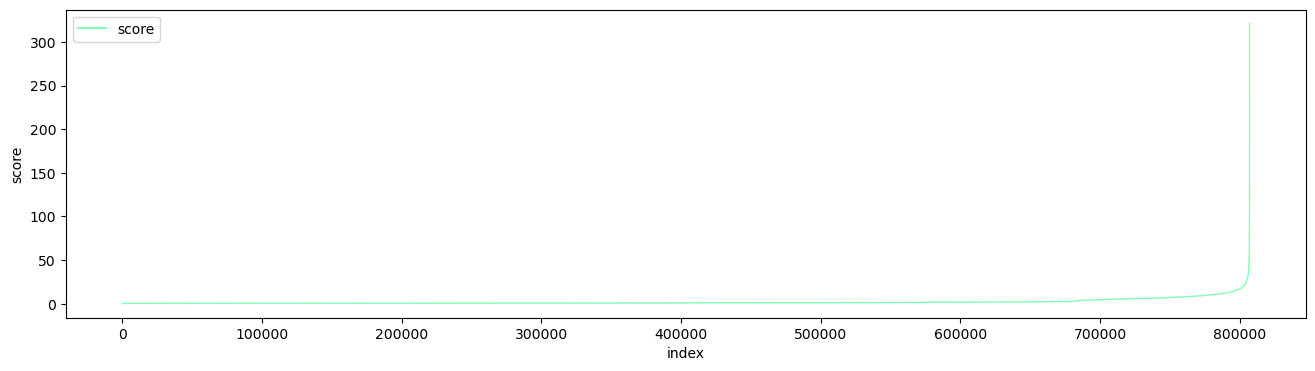

time: 5.44 s


In [27]:
# section_len >> score
wiktionary = pak.rename_col(wiktionary,'section_len','score')

# page_part 0 aufwerten
mask = (wiktionary.lemma == wiktionary.section_id2)
wiktionary.loc[mask,'score'] = wiktionary[mask].score * 3

wiktionary['score'] = pak.scale( wiktionary.score, 'compare_median')
mask = wiktionary.score < 0.01
wiktionary.loc[mask,'score'] += 0.01

%matplotlib inline
a = wiktionary.score.sort_values().reset_index(drop=True)
pak.plot(a)

In [28]:
grid(wiktionary, pak.sample)

11 rows out of 806916


time: 5.64 s


## Steuertabellen laden

In [29]:
blab.help(plan_merkmal_erstellen)

* definiert in Steuertabellen/s01_Steuertabellen.py
* `merkmal`: Name des Merkmals
* `template`: Name des Mediawiki-Templates, das diese Information enthält
* `collect`: Extractionsmethode
   * L extrahiert nur Links 
   * T extrahiert komplette Text-Absätze
   * Ü extrahiert Übersetzungen
   * P extrahiert Template-Parameter (Substring reicht)
   * E checkt nur auf Existenz
* `plan`:
   * 1: die Merkmale, die in wiktionary_merkmal gespeichert werden
   * 2: die Merkmale, die in wiktionary_merkmal_text gespeichert werden   
   * 3: Reihenfolge und Liste aller Merkmale aus flexion / übersicht <br>
        sowie die Merkmale aus named_entities und lexeme_manuell
* `sort`: Irgendwas zum Sortieren der Merkmale
* `is_lex`: Ist das Merkmal ein Lexem?    

time: 28.8 ms


In [30]:
# plan_merkmal Steuertabelle
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
grid(plan_merkmal)

103 rows


time: 243 ms


In [31]:
# translate_tag: Wortarten >> tags

try:
    del translate_tag
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tag)

179 rows


time: 80.8 ms


In [32]:
# translate_tagZ: tag >> tagZ und tagZZ

try:
    del translate_tagZ
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
grid(translate_tagZ)

62 rows


time: 110 ms


In [33]:
# lex_test, lemma_test
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1)
grid(lemma_test)

74 rows loaded
Delete 15 rows from 74
49 rows


time: 1.05 s


## Löschliste
* Excel-Datei aufbereiten
* wiktionary belöschen
* wiktionary_merkmal belöschen
* Falls löschliste und lexeme_manuell in Konflikt stehen, siegt lexeme_manuell. Es wird erst gelöscht und dann manuell ergänzt.

In [34]:
# Laden
löschliste = pak.load_excel( löschliste_filename )

379 rows loaded
time: 201 ms


In [35]:
# Format prüfen
löschliste['check'] = löschliste.isnull().sum(axis=1)
mask = löschliste.check != 2
error = check_mask(löschliste,mask,0, stop=False)
grid(löschliste,mask, color='green')

check_mask:  0 rows
No rows, mask filters them all away
time: 85.4 ms


In [36]:
löschliste = pak.drop_cols(löschliste,'check')
bpy.raise_if(error)

time: 55.2 ms


In [37]:
# Einzelne löschlisten

mask = löschliste.section_id2.notnull()
löschliste_section_id2 = list(löschliste[mask].drop_duplicates().section_id2)

mask = löschliste.lemma.notnull()
löschliste_lemma = list(löschliste[mask].drop_duplicates().lemma)

mask = löschliste.lex.notnull()
löschliste_lex = list(löschliste[mask].drop_duplicates().lex)
löschliste_lex += löschliste_lemma

time: 56.2 ms


In [38]:
# löschliste_lemma nach löschliste_section_id2 übertragen
mask1 =  wiktionary.title.isin(löschliste_lemma)   &   (wiktionary.title == wiktionary.lemma)
mask2 = ~wiktionary.section_id2.isin(löschliste_section_id2)
mask = mask1  &  mask2
#wiktionary[mask]
löschliste_section_id2 += list(wiktionary[mask].section_id2)

time: 243 ms


In [39]:
# wiktionary belöschen nach section_id2
mask = wiktionary.section_id2.isin(löschliste_section_id2)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_section_id2' )       # Löschen

Move 288 rows from 806916
time: 683 ms


In [40]:
# wiktionary belöschen nach lex
mask = wiktionary.title.isin(löschliste_lex)   
wiktionary, wiktionary_trash = pak.move_rows( df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='löschliste_lex' )       # Löschen

Move 51 rows from 806628
time: 683 ms


In [41]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_section_id2')

mask = wiktionary_merkmal_trash.msg == 'löschliste_section_id2'
grid(wiktionary_merkmal_trash,mask)

Move 3568 rows from 3137375
3568 rows


time: 2.05 s


In [42]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_lex')

mask = wiktionary_merkmal_trash.msg == 'löschliste_lex'
grid(wiktionary_merkmal_trash,mask)

Move 654 rows from 3133807
654 rows out of 4222


time: 1.92 s


In [43]:
# aufräumen
del löschliste_lemma
del löschliste

time: 44.5 ms


## wiktionary tag und member
* Aus dem Feld pos entstehen die Felder tag (standardisiert) und member (vollständig)

In [44]:
# Kaputte Datenstruktur in str wandeln
wiktionary['tag'] = wiktionary.pos.apply( lambda x: str(x) )
wiktionary = pak.move_cols(wiktionary,'tag','pos')

# translate
translate_chars = str.maketrans("{}'[]:", "     ,")
wiktionary.tag = wiktionary.tag.str.translate(translate_chars)

# Liste ohne Dups draus machen
wiktionary.tag = wiktionary.tag.str.split(",")
wiktionary.tag = wiktionary.tag.apply( lambda x: list(set(x)) )

# Strings pflegen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e.strip().replace(' ','_')  for e in x ] )

# Leere Strings entfernen
wiktionary.tag = wiktionary.tag.apply( lambda x: [ e for e in x  if e != ''] )

time: 6.29 s


In [45]:
#grid(wiktionary, pak.sample)

time: 31.2 ms


In [46]:
# nach Priorität sortieren (laut Steuertabellen)
wiktionary.loc[:,'tag'] = member_sortieren(wiktionary.tag) 

time: 2.23 s


In [47]:
# In string wandeln
wiktionary.tag = wiktionary.tag.str.join(' ')

time: 235 ms


In [48]:
# translate_first

print(translate_first1)
print(translate_first2)

wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first1).str.strip()
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_first2).str.strip()

[('  ', ' '), ('Partizip II', 'Ptz2'), ('Partizip_II', 'Ptz2'), ('PartizipII', 'Ptz2'), ('Konjunktiv II', 'Konj2'), ('Konjunktiv_II', 'Konj2'), ('KonjunktivII', 'Konj2'), ('  ', ' ')]
[('  ', ' '), ('Partizip I', 'Ptz1'), ('Partizip_I', 'Ptz1'), ('PartizipI', 'Ptz1'), ('Konjunktiv I', 'Konj1'), ('Konjunktiv_I', 'Konj1'), ('KonjunktivI', 'Konj1'), ('  ', ' ')]
time: 4.05 s


In [49]:
#mask = (wiktionary.tag.str.count(' ') + 1)  > 2   
#wiktionary[mask]

time: 35 ms


In [50]:
grid(wiktionary, pak.sample)

11 rows out of 806577


time: 7.58 s


In [51]:
pak.analyse_cols(wiktionary)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,806577,0,0,806577,0.0,403501.35,403502.0,806915.0,3.254549e+11
1,page_id,int64,np.int64,int64,pd.Int32,True,False,True,False,80.0 B,1,771982,0,34595,806577,0.0,603389.28,595029.0,1078351.0,4.866799e+11
2,page_part,int64,np.int64,int64,pd.Int8,True,False,True,False,80.0 B,1,6,0,806571,806577,0.0,0.05,0.0,5.0,3.649400e+04
3,section_id2,str,object,object,pd.string,False,True,True,True,722.0 B,1,806577,0,0,806577,&c.,NaN,NaN,μm,NaN
4,title,str,object,object,pd.string,False,True,True,True,720.0 B,1,771981,0,34596,806577,&c.,NaN,NaN,μm,NaN
5,lemma,str,object,object,pd.string,False,True,True,True,676.0 B,1,153537,0,653040,806577,&c.,NaN,NaN,μm,NaN
6,inflected,bool_,bool,bool,,True,False,True,True,10.0 B,1,2,0,806575,806577,0.0,0.83,NaN,1.0,6.717590e+05
7,pos,dict,object,object,,False,True,False,True,2.2 KB,1,163,0,806414,806577,NaN,NaN,NaN,NaN,NaN
8,tag,str,object,object,pd.string,False,True,True,True,686.0 B,1,156,0,806421,806577,Abkürzung,NaN,NaN,Wortverbindung Partikel,NaN
9,rhymes,list,object,object,,False,True,False,True,464.0 B,1,38306,503544,264727,806577,[a],NaN,NaN,"[ʏʃəs, yːʃəs]",NaN


time: 10.2 s


In [52]:
# Spalte member bewahrt die ursprüngliche Klassifizierung vollständig
wiktionary['member'] = wiktionary.tag.copy()
wiktionary = pak.move_cols(wiktionary,'member','tag')

time: 901 ms


In [53]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 806577


time: 127 ms


In [54]:
grid(translate_tag)

179 rows


time: 110 ms


In [55]:
# anwenden
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

time: 42.1 s


In [56]:
# Durchlauf2: translate_tag erneut anwenden 
mask = translate_tag.notiz.str.contains('Durchlauf2')
wiktionary['tag'] = pak.replace_str( wiktionary.tag, translate_tag[mask] )
wiktionary['tag'] = wiktionary.tag.str.replace('  ',' ').str.strip()    

time: 15.7 s


In [57]:
# tag TODO für alles, was noch weiterverarbeitet werden muss
mask = (wiktionary.tag.str.len() == 0)
wiktionary.loc[mask,'tag'] = 'TODO'
#grid(wiktionary,mask)

time: 287 ms


In [58]:
# wiktionary anschauen
#mask = wiktionary.tag == 'ADJA ADV PRO'
mask = wiktionary.title.isin( suche_debug )
grid(wiktionary,mask)

3 rows out of 806577


time: 906 ms


In [59]:
# Dekliniertes_Gerundivum: beizubehaltende
# VMaßeinheiten

time: 51.5 ms


## Bindestrich

In [60]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.section_id2.isin(suche)
check_mask(wiktionary,mask,4,4)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
wiktionary.loc[mask,'member']      = 'Adjektiv'
wiktionary.loc[mask,'tag']         = 'ADJA'
wiktionary.loc[mask,'pos']         = {'Adjektiv': []}
wiktionary.loc[mask,'section_id2'] = wiktionary[mask].section_id2.str.replace('-','_glex')
wiktionary[mask]

check_mask:  4 rows


,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,member,rhymes,score,flexion,ipa,syllables,lang,lang_code,error,lemma_lower
25823,67995,0,unter_glex,unter,unter,False,NaN,ADJA,Adjektiv,NaN,8.894032,{},[ʊntɐ],"[un, ter]",Deutsch,de,,unter
213892,379521,0,ober_glex,ober,ober,False,NaN,ADJA,Adjektiv,NaN,6.716200,{},[ˈoːbɐ],[ober],Deutsch,de,,ober
457097,680245,0,äußer_glex,äußer,äußer,False,NaN,ADJA,Adjektiv,NaN,11.130329,"{'Positiv': ['äußer(er)'], 'Superlativ': ['äuß...",[ˈɔɪ̯səʁɐ],NaN,Deutsch,de,,äußer
457110,680259,0,inner_glex,inner,inner,False,NaN,ADJA,Adjektiv,NaN,11.298417,"{'Positiv': ['inner(er)'], 'Superlativ': ['inn...",[ˈɪnɐ],NaN,Deutsch,de,,inner


time: 289 ms


In [61]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.section_id2.isin(suche)
check_mask(wiktionary_merkmal,mask,80)
wiktionary_merkmal.loc[mask,'section_id2'] = wiktionary_merkmal[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal[mask]

check_mask:  80 rows
time: 312 ms


In [62]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal_text
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal_text.section_id2.isin(suche)
check_mask(wiktionary_merkmal_text,mask,46)
wiktionary_merkmal_text.loc[mask,'section_id2'] = wiktionary_merkmal_text[mask].section_id2.str.replace('-','_glex')
#wiktionary_merkmal_text[mask]

check_mask:  46 rows
time: 108 ms


In [63]:
# Gebundene Adjektiv-Lexeme in wiktionary
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary.lemma.isin(suche)
check_mask(wiktionary,mask,36)

wiktionary.loc[mask,'title']       = wiktionary[mask].title.str.replace('-','')
wiktionary.loc[mask,'lemma']       = wiktionary[mask].lemma.str.replace('-','')
wiktionary.loc[mask,'lemma_lower'] = wiktionary[mask].lemma_lower.str.replace('-','')
#grid(wiktionary,mask)

check_mask:  36 rows
time: 135 ms


In [64]:
# Gebundene Adjektiv-Lexeme in wiktionary_merkmal
suche = ['ober-','unter-','äußer-','inner-',]
mask = wiktionary_merkmal.data.isin(suche)
check_mask(wiktionary_merkmal,mask,0,10)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.replace('-','')
wiktionary_merkmal[mask]

check_mask:  1 rows


,section_id2,merkmal,node_debug,node_kontext,data,num,meta
643279,unter-_1,übersicht,Deutsch Adjektiv Übersicht,Positiv,unter,,<NA>


time: 394 ms


In [65]:
# AFIX 588
mask0 = ~wiktionary.lemma.str.startswith('-')   
mask1 =  wiktionary.lemma.str.endswith('-')  
mask2 = ~wiktionary.lemma.str[0].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 700)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'AFIX ' + wiktionary[mask].tag

check_mask:  547 rows
time: 1.37 s


In [66]:
# ZFIX
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 = ~wiktionary.lemma.str.endswith('-')
mask2 = ~wiktionary.lemma.str[-1].str.isdigit()
mask3 =  wiktionary.lemma.str.len() > 1
mask4 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3  &  mask4 
pak.check_mask(wiktionary, mask, 0, 600)
#grid(wiktionary, mask)
#pak.analyse_freqs(wiktionary[mask], 'tag')
wiktionary.loc[ mask, 'tag'] = 'ZFIX ' + wiktionary[mask].tag

check_mask:  473 rows
time: 1.37 s


In [67]:
# MFIX >> löschen
mask0 =  wiktionary.lemma.str.startswith('-')
mask1 =  wiktionary.lemma.str.endswith('-') 
mask2 =  wiktionary.lemma.str.len() > 2
mask3 = ~wiktionary.tag.str.contains(' ')   
mask = mask0  &  mask1  &  mask2  &  mask3
check_mask(wiktionary, mask, 0, 4)
#grid(wiktionary, mask)
#analyse_freqs(wiktionary[mask], 'tag')
wiktionary, wiktionary_trash = pak.move_rows(df_from=wiktionary, df_to=wiktionary_trash, mask=mask, msg='MFIX') 

check_mask:  4 rows
Move 4 rows from 806577
time: 1.69 s


## wiktionary Einzelkorrekturen

In [68]:
# Beispiele anzeigen
mask = wiktionary.member.str.contains('VMaßeinheiten')
grid(wiktionary,mask, color=None)

No rows, mask filters them all away
time: 323 ms


In [69]:
# anschauen
a = pak.analyse_freqs( wiktionary, ['member', 'tag'], splits=[' ',None])
grid(a)

68 rows


time: 5.51 s


In [70]:
# Einzelkorrekturen        
einzelkorrekturen = { 'viel'        : 'ADJA PIAT',  # war: ADJA ADV PIAT CARD
                      'zig'         : 'ADJA',
                      'bis'         : 'KOUS APPR',      
                      'derentwegen' : 'PDAT PRELAT',
                      'Fachleute'   : 'NN',
                      'Rheinland'   : 'NE',                 
}
for i,t in einzelkorrekturen.items():
    mask = (wiktionary.section_id2 == i)
    wiktionary.loc[mask,'tag'] = t

time: 465 ms


In [71]:
# pflege_tag_felder (schreibe tagZZ usw.)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

time: 29.9 s


## named_entities

In [72]:
# laden
named_entities = pak.load_excel(named_entities_filename, tabcol='quelle')

4544 rows loaded
time: 875 ms


In [73]:
# Überblick
a = pak.analyse_freqs(named_entities, cols=['quelle','member','lemma'], splits=[None,' '])
grid(a)

3 rows


time: 177 ms


In [74]:
# Felder ergänzen
named_entities['title']       = named_entities.lemma
named_entities['lemma_lower'] = named_entities.lemma.str.lower() 
named_entities = pak.move_cols( named_entities, 'lemma_lower','lemma')

time: 104 ms


In [75]:
# section_id2
named_entities['section_id2'] = named_entities.lemma + '_' + named_entities.quelle.str[0].str.upper().copy()
named_entities['section_id2'] = named_entities.section_id2.str.replace(' ','_').copy()
named_entities = pak.move_cols(named_entities, ['section_id2','title'])

time: 116 ms


In [76]:
# Bekannte section_id2 aus wiktionary übertragen. Aber nur wenn der tag wirklich gleich ist.
mask = (wiktionary.lemma == wiktionary.title)  # wichtig
named_entities = pak.update_col(named_entities, wiktionary[mask], on=['lemma_lower','tag'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 2213 records less!
update_col: 1242 cells written into existing column
time: 991 ms


In [77]:
# drop_cols
named_entities = pak.drop_cols(named_entities,['sex_f', 'sex_m', 'Land', 'Stadt','quelle'])

time: 42.5 ms


In [78]:
# score erhöhen
named_entities.score += 1.0
named_entities.score *= 2.0

time: 48.2 ms


In [79]:
grid(named_entities, pak.sample)

7 rows out of 4544


time: 287 ms


In [80]:
# Dups?
mask = named_entities.section_id2.duplicated()
check_mask(named_entities,mask,0,0)

check_mask:  0 rows
time: 79 ms


In [81]:
?pak.cols_to_dict

time: 100 ms


Signature:
pak.cols_to_dict(
    df,
    col_dict='',
    cols_add=[],
    use_defaultdict=False,
    drop=True,
)
Docstring:
Moves columns into a dict or defaultdict.
This is 
* col_dict:         name of the target column. Can be empty, but may already contain a dict or defaultdict. 
* cols_add:         Columns to be packed.
* use_defaultdict:  Should a defaultdict be used as data structure? Otherwise keys can only occur once.
* drop:             Should the packed columns be dropped (>> move) or not (>> copy)?
File:      ~/mambaforge/envs/python_06/lib/python3.9/site-packages/pandasklar/aggregate.py
Type:      function


In [82]:
named_entities = pak.cols_to_dict(named_entities,col_dict='flexion',cols_add=['Genus','Nom Sg','Gen Sg',], use_defaultdict=True)
named_entities

,section_id2,title,lemma,lemma_lower,tag,member,score,flexion
0,Hagen,Hagen,Hagen,hagen,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Hagen'], 'Gen Sg'..."
1,Jordan,Jordan,Jordan,jordan,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Jordan'], 'Gen Sg..."
2,Menzel_V,Menzel,Menzel,menzel,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Menzel'], 'Gen Sg..."
3,Oswald_V,Oswald,Oswald,oswald,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Oswald'], 'Gen Sg..."
4,Reinhardt_V,Reinhardt,Reinhardt,reinhardt,NE,Vorname Nachname,2.989899,"{'Genus': ['m'], 'Nom Sg': ['Reinhardt'], 'Gen..."
...,...,...,...,...,...,...,...,...
4539,Wolff,Wolff,Wolff,wolff,NE,Nachname,2.989899,"{'Nom Sg': ['Wolff'], 'Gen Sg': ['Wolffs']}"
4540,Wolter_N,Wolter,Wolter,wolter,NE,Nachname,2.989899,"{'Nom Sg': ['Wolter'], 'Gen Sg': ['Wolters']}"
4541,Zander_2,Zander,Zander,zander,NE,Nachname,2.989899,"{'Nom Sg': ['Zander'], 'Gen Sg': ['Zanders']}"
4542,Zeller_N,Zeller,Zeller,zeller,NE,Nachname,2.989899,"{'Nom Sg': ['Zeller'], 'Gen Sg': ['Zellers']}"


time: 2.98 s


In [83]:
grid(named_entities, pak.sample)

5 rows out of 4544


time: 368 ms


In [84]:
# anfügen
wiktionary = pak.add_rows(wiktionary, named_entities, assert_subset=True)

4544 rows added, now a total of 811117
time: 948 ms


In [85]:
# flexion type korrekt?
assert pak.ntypes(wiktionary.flexion) == 1

time: 327 ms


In [86]:
# wiktionary anschauen
mask = wiktionary.title.isin(suche_debug) 
r = wiktionary[mask].sort_values(['title','section_id2'])
grid(r)

3 rows


time: 649 ms


## Zahlwörter

In [87]:
# Wandelt eine Zahl in Worte um
def zahl_in_worten(n, s=True, z=False):
    
    w1 = "null ein zwei drei vier fünf sechs sieben acht neun zehn elf zwölf dreizehn vierzehn fünfzehn sechzehn siebzehn achtzehn neunzehn".split()
    w2 = "zwanzig dreißig vierzig fünfzig sechzig siebzig achtzig neunzig".split()    
    if n < 0: raise ValueError
    if n == 0 and z: return ""
    if n == 1 and s: return "eins"
    if n < 20: return w1[n]
    if n < 100:
        w = w2[(n - 20) // 10]
        if n % 10:
            w = w1[n % 10] + "und" + w
        return w
    if n < 1000:
        return w1[n // 100] + "hundert" + zahl_in_worten(n % 100, z=True)
    if n < 1000000:
        return zahl_in_worten(n // 1000, s=False) + "tausend" + zahl_in_worten(n % 1000, z=True)
    raise ValueError

time: 64.7 ms


In [88]:
print(zahl_in_worten(3107))

dreitausendeinhundertsieben
time: 71.7 ms


In [89]:
def zahlwörter_liste(range_): 
    return [ 
    {'lex' : [zahl_in_worten(z), str(z)], 
     'lemma' : zahl_in_worten(z),      
     'def'   : str(z),
    } for z in range_]

zahlwörter_liste(range(0,20,10))

[{'lex': ['null', '0'], 'lemma': 'null', 'def': '0'},
 {'lex': ['zehn', '10'], 'lemma': 'zehn', 'def': '10'}]

time: 48.6 ms


In [90]:
# 0..99 zahlwörter_a erzeugen
range_ = range(0,100)
zahlwörter_a = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_a

time: 50.7 ms


In [91]:
# Hunderter Zahlwörter erzeugen
range_ = range(100,1000,100)
zahlwörter_b = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_b

time: 54.2 ms


In [92]:
# Tausender Zahlwörter erzeugen
range_ = range(1000,99001,1000)
zahlwörter_c = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_c

time: 48.8 ms


In [93]:
# Zehntausender Zahlwörter erzeugen
range_ = range(10000,99001,10000)
zahlwörter_d = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_d

time: 33.3 ms


In [94]:
# Hunderttausender Zahlwörter erzeugen
range_ = range(100000,990001,100000)
zahlwörter_e = pd.DataFrame(zahlwörter_liste( range_ ))
#zahlwörter_e

time: 37.8 ms


In [95]:
# concat
zahlwörter_all = pd.concat([  zahlwörter_a, zahlwörter_b, zahlwörter_c, zahlwörter_d, zahlwörter_e,  ])

time: 38.7 ms


In [96]:
# explode lex
zahlwörter_all = zahlwörter_all.explode('lex')

time: 49 ms


In [97]:
# Sonstige Spalten
zahlwörter_all['tag']         = 'CARD'
zahlwörter_all['tag_lex']     = 'lex' # ja
zahlwörter_all['genus']       = 'f'
zahlwörter_all['member']      = 'Zahlwort'
zahlwörter_all['tab']         = 'Zahlwort' # Wird später wieder gelöscht, dient der Kompatibilität zu lexeme_manuell

time: 46.1 ms


In [98]:
# Substantive ergänzen
mask = zahlwörter_all.lex == zahlwörter_all.lemma
df = zahlwörter_all[mask].copy()
df['lex']   = df.lex.str.capitalize()
df['lemma'] = df.lex.str.capitalize()
df['tag']   = 'NN'
zahlwörter_all = pak.add_rows(zahlwörter_all, df)
#df

226 rows added, now a total of 678
time: 48.1 ms


In [99]:
# zahlwörter_all anschauen
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


time: 183 ms


## lexeme_manuell

In [100]:
# laden
lexeme_manuell = pak.load_excel( lexeme_manuell_filename, tabcol='tab' )
lexeme_manuell = pak.move_cols(  lexeme_manuell, 'tag_lex')

1794 rows loaded
time: 347 ms


In [101]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,genus,tab
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,<NA>,<NA>,Partizipien
90,Ptz2,mißraten,missraten,VVFIN,<NA>,<NA>,Partizipien
204,Ptz2,missraten,missraten,VVFIN,<NA>,<NA>,Partizipien


time: 63.5 ms


In [102]:
# Partizipien falsch definiert?
mask1  = lexeme_manuell.tag_lex.str.startswith('Ptz')
mask2A = lexeme_manuell.tab != 'Partizipien'
mask2B = lexeme_manuell.tag != 'VVFIN'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask,0)
#lexeme_manuell[mask]

check_mask:  0 rows
time: 46.8 ms


In [103]:
# Abkürzungen falsch definiert?
# Das Schlüsselwort 'Abkürzung' darf nirgends in lexeme_manuell vorkommen.
mask1A = lexeme_manuell.member.str.contains('Abkürzung')
mask1B = lexeme_manuell.member.str.contains('Abkürzung')
mask = (mask1A | mask1B) 
check_mask(lexeme_manuell,mask,0)
lexeme_manuell[mask]

check_mask:  0 rows


,tag_lex,lex,lemma,tag,member,genus,tab


time: 57.1 ms


In [104]:
pak.sample(zahlwörter_all)

,lex,lemma,def,tag,tag_lex,genus,member,tab
0,null,null,0,CARD,lex,f,Zahlwort,Zahlwort
237,10000,zehntausend,10000,CARD,lex,f,Zahlwort,Zahlwort
376,achtzigtausend,achtzigtausend,80000,CARD,lex,f,Zahlwort,Zahlwort
677,Neunhunderttausend,Neunhunderttausend,900000,NN,lex,f,Zahlwort,Zahlwort


time: 208 ms


In [105]:
# assert subset
assert set(zahlwörter_all.columns) - set(['def']) <= set(lexeme_manuell.columns)

time: 52.1 ms


In [106]:
# zahlwörter_all anfügen
lexeme_manuell = pak.add_rows(lexeme_manuell, zahlwörter_all)

678 rows added, now a total of 2472
time: 46.3 ms


In [107]:
# tab analysieren
pak.analyse_freqs( lexeme_manuell, cols='tab')

,tab,tab_count,tab_percent,graph
0,esszett,729,29.5,##############
1,Zahlwort,678,27.4,#############
2,Partizipien,414,16.7,########
3,Diverses,299,12.1,######
4,Abkuerzungen,156,6.3,###
5,FM,102,4.1,##
6,Symbole,48,1.9,
7,Partikel,44,1.8,
8,Namen,2,0.1,


time: 71.1 ms


In [108]:
# NaN

# def
lexeme_manuell['def'] = lexeme_manuell['def'].fillna('')

# member
mask = lexeme_manuell.member.isnull()   |   lexeme_manuell.member.isin(['nan'])
lexeme_manuell.loc[mask,'member'] = ''
lexeme_manuell.member += ' manuell'

# lemma und lex
mask = lexeme_manuell.lemma.isnull()   |   lexeme_manuell.lemma.isin(['nan',''])
lexeme_manuell.loc[mask,'lemma'] = lexeme_manuell[mask].lex
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

mask = lexeme_manuell.lex.isnull()   |   lexeme_manuell.lex.isin(['nan',''])
lexeme_manuell.loc[mask,'lex'] = lexeme_manuell[mask].lemma
lexeme_manuell.loc[mask,'member'] += ' ergänzt'

# genus
mask = lexeme_manuell.genus.isnull()   |   lexeme_manuell.genus.isin(['nan'])
lexeme_manuell.loc[mask,'genus'] = ''

# tag_lex
mask = lexeme_manuell.tag_lex.isnull()   |   lexeme_manuell.tag_lex.isin(['nan'])
lexeme_manuell.loc[mask,'tag_lex'] = ''

mask = (lexeme_manuell.lex != lexeme_manuell.lemma)   &   (lexeme_manuell.tag_lex == '')
lexeme_manuell.loc[mask,'tag_lex'] = 'lex'

mask = (lexeme_manuell.lex == lexeme_manuell.lemma)   &   (  (lexeme_manuell.tag_lex == 'lex')  | (lexeme_manuell.tag_lex == '')  )
lexeme_manuell.loc[mask,'tag_lex'] = 'lemma'

# tag
mask = lexeme_manuell.tag.isnull()   |   lexeme_manuell.tag.isin(['nan',''])
check_mask( lexeme_manuell, mask, 0, 0)

# Abschluss
lexeme_manuell.member = lexeme_manuell.member.str.strip()
lexeme_manuell = pak.rename_col(lexeme_manuell, 'genus','Genus')

#lexeme_manuell = pak.move_cols(lexeme_manuell, ['Genus','abk'], -1)
#lexeme_manuell['abk'] = ''

check_mask:  0 rows
time: 95.9 ms


In [109]:
# Dups löschen
mask = lexeme_manuell.duplicated()
lexeme_manuell, df = pak.move_rows(lexeme_manuell,mask)
grid(df)

Move 104 rows from 2472
104 rows


time: 100 ms


In [110]:
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lex,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


time: 416 ms


In [111]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


time: 78.4 ms


In [112]:
# strip
for c in lexeme_manuell.columns:
    lexeme_manuell[c] = lexeme_manuell[c].str.replace('  ',' ').str.strip()

time: 92.5 ms


In [113]:
# member analysieren
pak.analyse_freqs( lexeme_manuell, cols='member', splits=' ')

,member,member_count,member_percent,graph
0,manuell,2368,57.1,############################
1,lexAlt,653,15.7,#######
2,Zahlwort,651,15.7,#######
3,ergänzt,345,8.3,####
4,Einheit,56,1.3,
5,PRE,42,1.0,
6,Wortverbindung,28,0.7,
7,Ort,2,0.0,
8,modal,1,0.0,
9,Land,1,0.0,


time: 88.2 ms


In [114]:
# Derzeit nicht nötig: Ersetzungen im member
r = {  'Partizip1'          :  'Ptz1',        
       'Partizip_1'         :  'Ptz1',       
       'Partizip2'          :  'Ptz2',        
       'Partizip_2'         :  'Ptz2',   
       'Abkürzungen'        :  'Abkürzung',      
       'Abkürzung Abkürzung':  'Abkürzung',        
    }
lexeme_manuell['member'] = pak.replace_str(lexeme_manuell.member, r)
#grid(lexeme_manuell)

time: 56.2 ms


In [115]:
# Partizipien: tag_lex setzen 
mask = lexeme_manuell.member.str.contains('Ptz1')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz1'

mask = lexeme_manuell.member.str.contains('Ptz2')
lexeme_manuell.loc[mask,'tag_lex'] = 'Ptz2'

time: 56.2 ms


In [116]:
# These: Auch member muss gesetzt werden, weil Partizipien ja doppelt eingetragen werden
# NEIN: Das Partizip wandert ja nach flexion
#mask1 =  lexeme_manuell.tag_lex.str.startswith('Ptz')
#mask2 = ~lexeme_manuell.member.str.contains('Ptz1')
#mask3 = ~lexeme_manuell.member.str.contains('Ptz2')
#mask = mask1  &  mask2  &  mask3
#lexeme_manuell.loc[mask,'member'] = lexeme_manuell[mask].member + ' ' + lexeme_manuell[mask].tag_lex
#grid(lexeme_manuell[mask])

time: 46.2 ms


In [117]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


time: 73.8 ms


In [118]:
# Tab Esszett: tag_lex setzen
mask1 = lexeme_manuell.tab == 'esszett'
mask2A = lexeme_manuell.tag_lex == ''
mask2B = lexeme_manuell.tag_lex == 'lex'
mask = mask1  &  (mask2A | mask2B)
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'tag_lex'] = 'lexAlt'

check_mask:  653 rows
time: 38.8 ms


In [119]:
# Tab Esszett: member setzen
mask1 =  lexeme_manuell.tab == 'esszett'
mask2 = ~lexeme_manuell.member.str.contains('lexAlt')
mask = mask1  &  mask2
check_mask(lexeme_manuell,mask)
lexeme_manuell.loc[mask,'member'] += 'lexAlt'

check_mask:  0 rows
time: 56.3 ms


In [120]:
# Tab Abkuerzungen: tag_lex setzen
mask = (lexeme_manuell.tab == 'Abkuerzungen')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

mask = lexeme_manuell.member.str.contains('Abkürzung')
lexeme_manuell.loc[mask,'tag_lex'] = 'abk'

time: 47.1 ms


In [121]:
# anschauen
pak.sample(lexeme_manuell)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
0,Ptz2,abberufen,abberufen,VVFIN,manuell,,Partizipien,
482,lex,Kids,Kid,NN,manuell,n,Diverses,
497,lex,musses,müssen,VMFIN,manuell,,Diverses,
554,ADV,zu viele,zu viel,ADV,manuell,,Diverses,
653,lemma,5G,5G,NN,manuell ergänzt,,Diverses,
713,lex,❀,_,$(,manuell,,Symbole,
715,syn,[,(,$(,manuell,,Symbole,
748,lemma,!,!,$.,manuell ergänzt,,Symbole,
751,lemma,…,…,$(,manuell ergänzt,,Symbole,
1014,lexAlt,gewiß,gewiss,ADV,modal lexAlt manuell,,esszett,


time: 278 ms


In [122]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


time: 83.8 ms


In [123]:
# tag_lex analysieren
r = pak.analyse_freqs(lexeme_manuell, ['tag_lex', 'lex', 'member'], splits=[None,None,' '])
grid(r)

11 rows


time: 124 ms


In [124]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,tag_lex,lex,lemma,tag,member,Genus,tab,def
61,Ptz2,gefriergetrocknet,gefriertrocknen,VVFIN,manuell,,Partizipien,
90,Ptz2,mißraten,missraten,VVFIN,manuell,,Partizipien,
204,Ptz2,missraten,missraten,VVFIN,manuell,,Partizipien,


time: 97 ms


In [125]:
# Kopie erzeugen, verwenden wir später um alle Partizipien als Adjektive einpflegen zu können
lexeme_manuell_copy = lexeme_manuell.copy()

time: 60.5 ms


In [126]:
# Spalte flexion erstellen
lexeme_manuell['lex_bak'] = lexeme_manuell.lex.copy()
lexeme_manuell = pak.implode_to_defaultdict(lexeme_manuell, col_key='tag_lex', col_value='lex', col_result='flexion')

0 rows less, now 2368 rows
time: 2.12 s


In [127]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,lex_bak,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,gefriergetrocknet,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,missraten,{'Ptz2': ['missraten']}
1546,missraten,VVFIN,manuell,,Partizipien,,mißraten,{'Ptz2': ['mißraten']}


time: 58 ms


In [128]:
# lex == lemma: flexion soll leeres defaultdict sein
mask = (lexeme_manuell.lex_bak == lexeme_manuell.lemma) 
lexeme_manuell.loc[mask,'flexion'] = lexeme_manuell[mask].flexion.apply(lambda x: defaultdict(list))  # auf leeres defaultdict setzen
lexeme_manuell = pak.drop_cols(lexeme_manuell, 'lex_bak')
#grid(lexeme_manuell,~mask)

time: 39.4 ms


In [129]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,Genus,tab,def,flexion
1329,gefriertrocknen,VVFIN,manuell,,Partizipien,,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,,Partizipien,,{}
1546,missraten,VVFIN,manuell,,Partizipien,,{'Ptz2': ['mißraten']}


time: 74 ms


In [130]:
# Weitere Spalten in flexion verpacken (mit cols_to_defaultdict
lexeme_manuell = pak.cols_to_defaultdict(  lexeme_manuell, col_dict='flexion', cols_add=['Genus','def']   )  

time: 266 ms


In [131]:
# Spalte tab brauchen wir nicht mehr >> löschen
lexeme_manuell = pak.drop_cols(lexeme_manuell, ['tab'])

time: 36.2 ms


In [132]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,tag,member,flexion
1329,gefriertrocknen,VVFIN,manuell,{'Ptz2': ['gefriergetrocknet']}
1545,missraten,VVFIN,manuell,{}
1546,missraten,VVFIN,manuell,{'Ptz2': ['mißraten']}


time: 65.8 ms


In [133]:
# gruppieren
lexeme_manuell = pak.group_and_agg(lexeme_manuell,
                               ['lemma', 'tag',   'member',              'flexion',            ],
                               ['group', 'group',  pak.agg_words_nodup,  pak.agg_defaultdicts, ],
                               ['lemma', 'tag',   'member',              'flexion',            ]
                              )

577 rows less, now 1791 rows
time: 979 ms


In [134]:
# Felder ergänzen
lexeme_manuell['title']       = lexeme_manuell.lemma
lexeme_manuell['lemma_lower'] = lexeme_manuell.lemma.str.lower() 
lexeme_manuell = pak.move_cols( lexeme_manuell, 'lemma_lower','lemma')

time: 47.6 ms


In [135]:
# tagZ und tagZZ ermitteln
lexeme_manuell = pflege_tag_felder(lexeme_manuell, translate_tagZ)

time: 119 ms


In [136]:
# anschauen
grid(lexeme_manuell, pak.sample_100)

100 rows out of 1791


time: 265 ms


In [137]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1090,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,E9HfVlVodG,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']},gefriertrocknen
1235,missraten,missraten,VVFIN,VVFIN,pEaXLD9Gtb,VER,V,manuell,{'Ptz2': ['mißraten']},missraten


time: 90.9 ms


In [138]:
# anschauen: mehr als ein tag
mask = (lexeme_manuell.tag.str.split().str.len() > 1)
lexeme_manuell[mask]

,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion,title
1635,welch,welch,PRELS PWAT,PRELS,PWAT,PRO,P,manuell,"{'lex': ['welche', 'welchem', 'welchen', 'welc...",welch


time: 109 ms


In [139]:
# section_id2 schreiben
lexeme_manuell['section_id2'] = lexeme_manuell.lemma.str.replace(' ','_') + '_M'
mask = lexeme_manuell.tag == 'CARD'
lexeme_manuell.loc[mask,'section_id2'] = lexeme_manuell[mask].lemma.str.replace(' ','_') + '_Z'
lexeme_manuell = pak.move_cols(lexeme_manuell, ['section_id2','title'])

time: 51.4 ms


In [140]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen_M,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,E9HfVlVodG,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten_M,missraten,missraten,missraten,VVFIN,VVFIN,pEaXLD9Gtb,VER,V,manuell,{'Ptz2': ['mißraten']}


time: 83.1 ms


In [141]:
#wiktionary

time: 30.1 ms


In [142]:
# Bekannte section_id2 aus wiktionary übertragen

mask = (wiktionary.lemma == wiktionary.title)  # wichtig! Gerade die Datensätze, die nicht darunter fallen, verursachen Probleme bei Partizipien.

# tagZZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZZ'], col='section_id2',  col_score='score'  )

#tagZ
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tagZ'],  col='section_id2',  col_score='score'  )

# tag
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma_lower','tag'],   col='section_id2',  col_score='score'  )

# Wenn ein sinnvoller tag fehlt, reicht lemma
mask = (wiktionary.lemma == wiktionary.title)   &   wiktionary.tag.str.contains('TODO')
lexeme_manuell = pak.update_col(lexeme_manuell, wiktionary[mask], on=['lemma'], col='section_id2',  col_score='score' )

update_col: col_score score applied, 3221 records less!
update_col: 1174 cells written into existing column
update_col: col_score score applied, 2242 records less!
update_col: 1150 cells written into existing column
update_col: col_score score applied, 3455 records less!
update_col: 1135 cells written into existing column
update_col: col_score score applied, 4 records less!
update_col: 34 cells written into existing column
time: 2.94 s


In [143]:
# suche_debug
search_str(lexeme_manuell, suche_debug)

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,flexion
1090,gefriertrocknen,gefriertrocknen,gefriertrocknen,gefriertrocknen,VVFIN,VVFIN,E9HfVlVodG,VER,V,manuell,{'Ptz2': ['gefriergetrocknet']}
1235,missraten,missraten,missraten,missraten,VVFIN,VVFIN,pEaXLD9Gtb,VER,V,manuell,{'Ptz2': ['mißraten']}


time: 67.1 ms


In [144]:
# anschauen
#grid(lexeme_manuell, pak.sample_100)

time: 34.1 ms


In [145]:
# anfügen
wiktionary = pak.add_rows(wiktionary, lexeme_manuell, assert_subset=True)

1791 rows added, now a total of 812908
time: 756 ms


In [146]:
# section_id2 ist jetzt nicht mehr eindeutig
mask = wiktionary.duplicated(subset=['section_id2'], keep=False)
check_mask(wiktionary,mask,4517) 
#a = wiktionary[mask].sort_values(['section_id2'])
#grid(a)

check_mask:  4874 rows
time: 679 ms


In [147]:
assert pak.ntypes(wiktionary.flexion) == 1

time: 244 ms


In [148]:
# wiktionary suche_debug
#grid(search_str(wiktionary, suche_debug))

time: 34.1 ms


## ipa, syllables & rhymes

In [149]:
# Datentypen sind in jeder Zeile gleich
assert pak.ntypes(wiktionary.ipa) == 1
assert pak.ntypes(wiktionary.syllables) == 1

time: 389 ms


In [150]:
# Listen zu Strings
mask = ~wiktionary.ipa.isnull()
wiktionary.loc[mask,'ipa'] = wiktionary[mask].ipa.str[0]

mask = ~wiktionary.syllables.isnull()
wiktionary.loc[mask,'syllables'] = wiktionary[mask].syllables.str.join('⇀')

mask = ~wiktionary.rhymes.isnull()
wiktionary.loc[mask,'rhymes'] = wiktionary[mask].rhymes.str[0]

time: 2.01 s


In [151]:
# cols_to_defaultdict
# 1 min
wiktionary = pak.cols_to_defaultdict( wiktionary, col_dict='flexion', cols_add=['ipa','syllables','rhymes']  )

time: 1min 33s


In [152]:
# wiktionary anschauen
grid(wiktionary, pak.sample)

14 rows out of 812908


time: 7.17 s


## flexion nach wiktionary_merkmal exploden
* hiernach muss die löschliste nochmal angewendet werden

In [153]:
# flexion: vorbereiten
mask1 = wiktionary.flexion.notnull() 
mask2 = wiktionary.flexion != {}
mask3 = wiktionary.flexion != defaultdict(list)
mask = mask1  &  mask2  &  mask3 

spalten = ['section_id2','flexion']
df = pak.explode_dict(wiktionary[spalten][mask], col_dict='flexion', col_key='node_kontext', col_value='data', from_defaultdict=True)
df['merkmal'] = 'flexion'

time: 1min 48s


In [154]:
# Beispiel anschauen
mask = df.section_id2 == suche_debug[0]
grid(df,mask)

3 rows out of 2899974


time: 974 ms


In [155]:
# Beispiel anschauen
mask = df.section_id2 == suche_debug[0]
grid(df,mask)

3 rows out of 2899974


time: 262 ms


In [156]:
# an wiktionary_merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df, assert_subset=True)
wiktionary   = pak.drop_cols(wiktionary, ['flexion'])  

2899974 rows added, now a total of 6033127
time: 6.03 s


In [157]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2.isin(suche_debug)
grid(wiktionary_merkmal,mask)

76 rows out of 6033127


time: 307 ms


## wiktionary in 3 Teile aufteilen

In [158]:
# suche_debug 
mask = wiktionary.title.isin(suche_debug)
grid(wiktionary[mask].sort_values(['section_id2',]))

5 rows


time: 246 ms


In [159]:
# pflege_tag_felder (zur Sicherheit noch mal)
wiktionary = pflege_tag_felder(wiktionary, translate_tagZ)

time: 24.4 s


In [160]:
# LEX-Kennzeichnung sollte eineindeutig sein, außer bei FIX
mask = wiktionary.tag.str.contains('LEX_')   &   wiktionary.tag.str.contains(' ')   &   ~wiktionary.tag.str.contains('FIX')
#grid(wiktionary,mask)
check_mask(wiktionary,mask, 0, 0)

check_mask:  0 rows
time: 825 ms


### wiktionary_partizip
* Enthält Partizipien in Form von Partizipialadjektiven
* Aber keine Verben mit Partizip-Lexem!

In [161]:
# Partizipien nach wiktionary_partizip abspalten
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.member.str.contains('Ptz')  
mask = mask1  &  mask2
wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

Move 26594 rows from 812908
time: 1.19 s


In [162]:
## verblieben in wiktionary
mask1 = (wiktionary.lemma == wiktionary.title)  
mask2 = wiktionary.lemma.isin(suche_debug) 
mask = mask1 & mask2
wiktionary[mask]

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
97982,242150.0,0.0,missraten,missraten,missraten,False,{'Verb': []},VVFIN,VVFIN,foLRX8vFnm,VER,V,Verb,4.472594,Deutsch,de,,missraten
121110,273380.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,{'Adjektiv': []},ADJA,ADJA,M9yT3byKKu,ADJ,A,Adjektiv,3.807552,Deutsch,de,,gefriergetrocknet
783784,1054310.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,{'Verb': []},VVFIN,VVFIN,TLhfFhOWFO,VER,V,Verb,14.422655,Deutsch,de,,gefriertrocknen
812207,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,NaN,NaN,VVFIN,VVFIN,dFIK2wex3d,VER,V,manuell,NaN,NaN,NaN,NaN,gefriertrocknen
812352,NaN,NaN,missraten,missraten,missraten,NaN,NaN,VVFIN,VVFIN,hMbvB8jNwL,VER,V,manuell,NaN,NaN,NaN,NaN,missraten


time: 329 ms


In [163]:
## jetzt in wiktionary_partizip
mask = wiktionary_partizip.lemma.isin(suche_debug) 
wiktionary_partizip[mask]

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
265548,446280.0,0.0,missratend,missratend,missraten,True,{'Adjektiv': ['Partizip I']},ADJA,ADJA,OPq9O6nf5c,ADJ,A,Adjektiv Ptz1,0.579592,Deutsch,de,,missraten
783793,1054319.0,0.0,gefriertrocknend,gefriertrocknend,gefriertrocknen,True,{'Adjektiv': ['Partizip I']},ADJA,ADJA,kaZEgQ6iRR,ADJ,A,Adjektiv Ptz1,0.467347,Deutsch,de,,gefriertrocknen


time: 49.3 ms


In [164]:
mask1 = wiktionary.tag == 'ADJA'
mask2 = wiktionary.lemma.isin(wiktionary_partizip.lemma) 
mask = mask1  &  mask2
wiktionary[mask]
#wiktionary, wiktionary_partizip = pak.move_rows( wiktionary, mask, msg=None )  

,page_id,page_part,section_id2,title,lemma,inflected,pos,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
2007,2843.0,2.0,wollen_2,wollen,wollen,False,{'Adjektiv': []},ADJA,ADJA,YvJjUvyek1,ADJ,A,Adjektiv,2.836784,Deutsch,de,,wollen
2287,3182.0,1.0,zwirnen_1,zwirnen,zwirnen,False,{'Adjektiv': []},ADJA,ADJA,EPMop9z3Z9,ADJ,A,Adjektiv,1.147381,Deutsch,de,,zwirnen
3485,5079.0,0.0,befangen,befangen,befangen,False,{'Adjektiv': []},ADJA,ADJA,ImAuItuuAQ,ADJ,A,Adjektiv,9.295981,Deutsch,de,,befangen
3590,5293.0,0.0,überlegen,überlegen,überlegen,False,{'Adjektiv': []},ADJA,ADJA,AC1yrtZfEo,ADJ,A,Adjektiv,6.507917,Deutsch,de,,überlegen
5613,8808.0,1.0,erfahren_1,erfahren,erfahren,False,{'Adjektiv': []},ADJA,ADJA,DskxYKG6cs,ADJ,A,Adjektiv,4.533496,Deutsch,de,,erfahren
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710959,978147.0,0.0,hornen,hornen,hornen,False,{'Adjektiv': []},ADJA,ADJA,T8YRMoXdQp,ADJ,A,Adjektiv,3.084044,Deutsch,de,,hornen
747367,1016920.0,0.0,auserlesen,auserlesen,auserlesen,False,{'Adjektiv': []},ADJA,ADJA,nPx0XLM2Ah,ADJ,A,Adjektiv,4.220463,Deutsch,de,,auserlesen
812140,NaN,NaN,erwachsen,erwachsen,erwachsen,NaN,NaN,ADJA,ADJA,rKgVvfZhJv,ADJ,A,manuell ergänzt,NaN,NaN,NaN,NaN,erwachsen
812723,NaN,NaN,vorbehalten_M,vorbehalten,vorbehalten,NaN,NaN,ADJA,ADJA,2VVORfGIqe,ADJ,A,manuell ergänzt,NaN,NaN,NaN,NaN,vorbehalten


time: 245 ms


### wiktionary_nolemma

In [165]:
wiktionary_nolemma       = wiktionary.head(0)
wiktionary_nolemma_trash = wiktionary.head(0)

time: 37.2 ms


In [166]:
# LEX-Datensätze nach wiktionary_nolemma verschieben
mask = wiktionary.tag.str.contains('LEX_')    
check_mask(wiktionary,mask,639734)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='tag_LEX' )  

check_mask:  645225 rows
Move 645225 rows from 786314
time: 4.24 s


In [167]:
# auch nach wiktionary_nolemma verschieben
mask = wiktionary.member.str.contains('Deklinierte_Form')   # 2 Datensätze
check_mask(wiktionary, mask, 0, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='member_Deklinierte_Form' )  

check_mask:  2 rows
Move 2 rows from 141089


/tmp/ipykernel_5908/3497270118.py:4: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



time: 2.42 s


In [168]:
# auch nach wiktionary_nolemma verschieben
mask = (wiktionary.title != wiktionary.lemma)               # Es waren mal 10 Datensätze, jetzt sind es 5501
check_mask(wiktionary, mask, 10)
wiktionary, wiktionary_nolemma = pak.move_rows( df_from=wiktionary, df_to=wiktionary_nolemma, mask=mask, msg='title_ungleich_lemma' )  

check_mask:  10 rows
Move 10 rows from 141087


/tmp/ipykernel_5908/3822427480.py:4: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



time: 2.32 s


In [169]:
# wiktionary suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

35 rows


time: 1.41 s


In [170]:
# wiktionary_nolemma: Spalten pflegen
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'title', 'lex')
wiktionary_nolemma = pak.rename_col(wiktionary_nolemma, 'section_id2','nolemma_id')
wiktionary_nolemma = pak.drop_cols(wiktionary_nolemma, ['pos','tag_anz','ipa','syllables','msg','page_id','page_part','inflected','rhymes'])
#wiktionary_nolemma = pak.rename_col( wiktionary_nolemma, 'tag_0', 'tag') # Jetzt gibt es definitiv keine Mehrfachtags mehr

time: 1.86 s


In [171]:
# anschauen
pak.sample(wiktionary_nolemma)

,nolemma_id,lex,lemma,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
29,lieben_1,lieben,lieb,LEX_A,LEX_A,JOgkJEwGzz,<NA>,,Deklinierte_Form,2.382460,Deutsch,de,,lieb
58,Polen_1,Polen,Pole,LEX_A,LEX_A,F4i5uCCH88,<NA>,,Deklinierte_Form,0.883673,Deutsch,de,,pole
11103,lift,lift,liften,LEX_V,LEX_V,yVMy4O4V2S,<NA>,,Konjugierte_Form Verb,0.538776,Deutsch,de,,liften
37431,Fachleute,Fachleute,Fachleute,NN,NN,fQsLHPCpnX,NOM,N,Deklinierte_Form Substantiv,8.773447,Deutsch,de,,fachleute
53819,durchzuhalten,durchzuhalten,durchhalten,LEX_V,LEX_V,tQ0RNnKgjF,<NA>,,Erweiterter_Infinitiv Verb,0.469388,Deutsch,de,,durchhalten
54153,anzudauern,anzudauern,andauern,LEX_V,LEX_V,4hq2czjeq9,<NA>,,Erweiterter_Infinitiv Verb,0.406122,Deutsch,de,,andauern
123288,Sprachdenkmälern,Sprachdenkmälern,Sprachdenkmal,LEX_A,LEX_A,zzyRguDHtz,<NA>,,Deklinierte_Form,0.475510,Deutsch,de,,sprachdenkmal
179493,Pressefotos,Pressefotos,Pressefoto,LEX_A,LEX_A,000JkDLydw,<NA>,,Deklinierte_Form,0.877551,Deutsch,de,,pressefoto
414845,Körpermasse_1,Körpermasse,Körpermasse,LEX_A,LEX_A,bIf1qblVpr,<NA>,,Deklinierte_Form,0.038776,Deutsch,de,,körpermasse
558381,zu_viele,zu viele,zu viel,TODO,TODO,p4fLUGwqEH,X_todo,X,Wortverbindung,1.412911,Deutsch,de,,zu viel


time: 5.58 s


### wiktionary_lemma

In [172]:
# wiktionary_lemma: erstellen und Spalten pflegen
wiktionary_lemma       = pak.drop_cols(wiktionary, ['title','pos'])
wiktionary_lemma_trash = wiktionary_lemma.head(0)

time: 183 ms


In [173]:
del wiktionary

time: 74.3 ms


In [174]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma, suche_debug))

5 rows


time: 236 ms


## Partizipien
Die Partizipien werden<br> 
a) an wiktionary_merkmal angefügt (als Partizip-Flexion des Verbs)<br> 
b) an wiktionary_lemma angefügt   (als Adjektiv mit member Partizip)

Danach findet sich alles aus wiktionary in wiktionary_lemma und wiktionary_nolemma

### wiktionary_partizip pflegen

In [175]:
# rename_col
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'section_id2', 'adjektiv_id' )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'title',       'adjektiv'    )
wiktionary_partizip = pak.rename_col(wiktionary_partizip,  'lemma',       'verb'        )

#wiktionary_partizip = pak.move_cols(wiktionary_partizip,'verb_lower','verb')

time: 153 ms


In [176]:
# drop_cols
lösche_spalten = ['pos','error','lang','lang_code','lemma_lower','inflected','tag_0','tag_1']
wiktionary_partizip = pak.drop_cols(wiktionary_partizip,lösche_spalten)

time: 194 ms


In [177]:
# change_datatype
wiktionary_partizip = pak.change_datatype(wiktionary_partizip)

change_datatype 
page_id              --> pd.Int32  
page_part            --> pd.Int8   
adjektiv_id          --> pd.string 
adjektiv             --> pd.string 
verb                 --> pd.string 
member               --> pd.string 
score                --> np.float32
change_datatype before: 12.6 MB after: 12.2 MB

time: 412 ms


In [178]:
# falsche Partizipien löschen
falsche_partizipien = ['sehen','hören','wollen','lassen','mögen','sollen',]
mask = wiktionary_partizip.adjektiv.isin(falsche_partizipien) 
check_mask(wiktionary_partizip, mask, 0, 6)
wiktionary_partizip, df = pak.move_rows(wiktionary_partizip, mask)
df

check_mask:  6 rows
Move 6 rows from 26594


,page_id,page_part,adjektiv_id,adjektiv,verb,tag,tagZ,tagZZ,member,score,msg
414,660,1,sehen_1,sehen,sehen,ADJA,ADJ,A,Adjektiv Ptz2,1.460414,8
1093,1459,1,hören_1,hören,hören,ADJA,ADJ,A,Adjektiv Ptz2,1.046285,8
2006,2843,1,wollen_1,wollen,wollen,ADJA,ADJ,A,Adjektiv Ptz2,0.808163,8
2015,2852,1,lassen_1,lassen,lassen,ADJA,ADJ,A,Adjektiv Ptz2,0.671429,8
6174,10018,1,mögen_1,mögen,mögen,ADJA,ADJ,A,Adjektiv Ptz2,0.673469,8
10302,17727,1,sollen_1,sollen,sollen,ADJA,ADJ,A,Adjektiv Ptz2,0.818367,8


time: 201 ms


In [179]:
#grid(wiktionary_partizip)

time: 31.2 ms


In [180]:
# wiktionary suche_debug
grid(search_str(wiktionary_partizip, suche_debug))

2 rows


time: 186 ms


In [181]:
# So sehen normale Partizipien 1 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz1')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

13263 rows out of 26588


time: 372 ms


In [182]:
# Dies sind kaputte Partizipien 1: Das verb ist falsch, kann aber leicht korrigiert werden
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 =  wiktionary_partizip.member.str.contains('Ptz1')
mask3 =  wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 =  wiktionary_partizip.verb.str.endswith(('end','ernd'))
mask = mask1  &  mask2  &  mask3  &  mask4

wiktionary_partizip.loc[mask,'verb'] = wiktionary_partizip[mask].verb.str[:-1]
grid(wiktionary_partizip,mask)

11 rows out of 26588


time: 201 ms


In [183]:
# So sehen normale Partizipien 2 aus
mask1 = wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask = mask1 & mask2
grid(wiktionary_partizip,mask)

13310 rows out of 26588


time: 499 ms


In [184]:
# Dies sind kaputte Partizipien 2: Das verb ist falsch, kann auch nicht gut korrigiert werden.
mask1 = ~wiktionary_partizip.verb.str.endswith(verbendungen)
mask2 = wiktionary_partizip.member.str.contains('Ptz2')
mask3 = wiktionary_partizip.adjektiv == wiktionary_partizip.verb
mask4 = wiktionary_partizip.verb.str.endswith('t')
mask = mask1  &  mask2  &  mask3  &  mask4
grid(wiktionary_partizip,mask)

4 rows out of 26588


time: 214 ms


In [185]:
# Kaputte Partizipien 2 löschen
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip = pak.drop_rows(wiktionary_partizip,mask)

check_mask:  4 rows
Delete 4 rows from 26588
time: 114 ms


In [186]:
# Gibt es weitere kaputte Partizipien?
mask = ~wiktionary_partizip.verb.str.endswith(verbendungen)
check_mask(wiktionary_partizip,mask,0)
#grid(wiktionary_partizip,mask)

check_mask:  0 rows
time: 65.5 ms


In [187]:
# Wenn es verb nicht auch als Wort gibt, dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = ~wiktionary_partizip.verb.isin(wiktionary_lemma.lemma)
check_mask(wiktionary_partizip,mask,0,10)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

check_mask:  5 rows
Move 5 rows from 26584


,page_id,page_part,adjektiv_id,adjektiv,verb,tag,tagZ,tagZZ,member,score,msg
7288,12269,2,versiert_2,versiert,versieren,ADJA,ADJ,A,Adjektiv Ptz2,0.710204,8
27682,72264,1,gesamt_1,gesamt,samen,ADJA,ADJ,A,Adjektiv Ptz2,0.516327,8
450813,673105,0,wullackend,wullackend,wullacken,ADJA,ADJ,A,Adjektiv Ptz1,0.453061,8
450814,673106,0,gewullackt,gewullackt,wullacken,ADJA,ADJ,A,Adjektiv Ptz2,0.400000,8
529769,788254,0,mechend,mechend,mechen,ADJA,ADJ,A,Adjektiv Ptz1,0.436735,8


time: 136 ms


In [188]:
mask = wiktionary_lemma.tagZZ == 'V'
pak.analyse_freqs( wiktionary_lemma[mask], ['tag', 'member'])
#wiktionary_lemma[mask]

,tag,tag_count,tag_percent,member,member_count
0,VVFIN,14052,99.9,"[Verb, manuell, lexAlt manuell, Verb Wortverbi...","[13516, 402, 84, 37, 11, 1, 1]"
1,VAFIN,7,0.0,"[Verb Hilfsverb, manuell]","[4, 3]"
2,VMFIN,7,0.0,"[manuell, lexAlt manuell]","[6, 1]"


time: 179 ms


In [189]:
# verb_id ermitteln
mask = wiktionary_lemma.tagZZ == 'V'
wiktionary_partizip = pak.update_col( wiktionary_partizip,  wiktionary_lemma[mask], 
                                      left_on='verb',       right_on='lemma', 
                                      col_rename='verb_id', col='section_id2',    
                                                            col_score='score' 
                                    )
wiktionary_partizip = pak.move_cols(wiktionary_partizip, 'verb_id','adjektiv')

update_col: col_score score applied, 873 records less!
update_col: 26578 cells written into new column
time: 332 ms


In [190]:
# keine verb_id? Dann ist das Müll und kann weg.
# Wenn man das nicht will: Als Partizipien in lexeme_manuell aufnehmen!

mask = wiktionary_partizip.verb_id.isnull()
check_mask(wiktionary_partizip,mask,0,5)
wiktionary_partizip,df = pak.move_rows(wiktionary_partizip,mask)
df

check_mask:  1 rows
Move 1 rows from 26579


,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score,msg
39483,107564,1,betroffen_1,betroffen,NaN,betroffen,ADJA,ADJ,A,Adjektiv Ptz2,0.357143,8


time: 95.3 ms


In [191]:
# member pflegen. Enthält danach genau Ptz1 x-oder Ptz2.
wiktionary_partizip['member'] = pak.remove_str(wiktionary_partizip.member,['Adjektiv','Wortverbindung'])
mask = ~wiktionary_partizip.member.isin(['Ptz1','Ptz2'])
check_mask(wiktionary_partizip,mask,0)
mask = wiktionary_partizip.member.isnull()  |  (wiktionary_partizip.member=='')
check_mask(wiktionary_partizip,mask,0)

check_mask:  0 rows
check_mask:  0 rows
time: 124 ms


In [192]:
# Dups sollten eigentlich nicht drin sein
mask = wiktionary_partizip.duplicated()
check_mask(wiktionary_partizip,mask,0)

check_mask:  0 rows
time: 154 ms


In [193]:
# wiktionary_partizip.member analysieren
#r = pak.analyse_freqs( wiktionary_partizip, ['member', 'verb','adjektiv'])
#r

time: 48.9 ms


In [194]:
mask = wiktionary_partizip.adjektiv.isin(['betroffen','dienend'])
wiktionary_partizip[mask]

,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score
61315,143534,0,dienend,dienend,dienen,dienen,ADJA,ADJ,A,Ptz1,1.381242


time: 84.7 ms


### Partizipien als Flexion des Verbs eintragen

In [195]:
#wiktionary_merkmal

time: 43.7 ms


In [196]:
# wiktionary_merkmal_partizip
wiktionary_merkmal_partizip = wiktionary_partizip.copy()
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'member',      'merkmal')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'verb_id',     'section_id2')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv_id', 'data_id')
wiktionary_merkmal_partizip = pak.rename_col(wiktionary_merkmal_partizip, 'adjektiv',    'data')
wiktionary_merkmal_partizip = pak.drop_cols(wiktionary_merkmal_partizip,['tag','tagZ','tagZZ','score','verb','page_id','page_part'])
wiktionary_merkmal_partizip = pak.move_cols(wiktionary_merkmal_partizip,['section_id2','merkmal'])
assert set(wiktionary_merkmal_partizip.columns) == set(['section_id2','merkmal','data_id','data'])
pak.sample(wiktionary_merkmal_partizip)

,section_id2,merkmal,data_id,data
471,dezidieren,Ptz2,dezidiert_2,dezidiert
368744,Acht_geben,Ptz1,Acht_gebend,Acht gebend
429793,modeln,Ptz1,modelnd,modelnd
452164,Bescheid_sagen,Ptz1,Bescheid_sagend,Bescheid sagend
461035,auswiegen,Ptz2,ausgewogen_1,ausgewogen
752996,übriglassen,Ptz1,übriglassend,übriglassend
806526,anspringen,Ptz1,anspringend,anspringend


time: 714 ms


In [197]:
# wiktionary_partizip suche_debug
search_str(wiktionary_merkmal_partizip, suche_debug)

,section_id2,merkmal,data_id,data
265548,missraten,Ptz1,missratend,missratend
783793,gefriertrocknen,Ptz1,gefriertrocknend,gefriertrocknend


time: 97.4 ms


In [198]:
# wiktionary_merkmal_partizip als merkmal anfügen
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, wiktionary_merkmal_partizip)

26578 rows added, now a total of 6059705
time: 2.03 s


### Partizipien als Adjektiv einpflegen

In [199]:
wiktionary_partizip.head(1)

,page_id,page_part,adjektiv_id,adjektiv,verb_id,verb,tag,tagZ,tagZZ,member,score
471,741,2,dezidiert_2,dezidiert,dezidieren,dezidieren,ADJA,ADJ,A,Ptz2,0.67551


time: 68 ms


In [200]:
wiktionary_lemma.head(1)

,page_id,page_part,section_id2,lemma,inflected,tag,tag_0,tag_1,tagZ,tagZZ,member,score,lang,lang_code,error,lemma_lower
0,0.0,0.0,Hallo,Hallo,False,NN,NN,kX5wyqKSJc,NOM,N,Substantiv,7.282582,Deutsch,de,,hallo


time: 76.8 ms


In [201]:
# wiktionary_lemma_partizip
wiktionary_lemma_partizip = wiktionary_partizip.copy()
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv_id',     'section_id2')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'adjektiv',        'lemma')
wiktionary_lemma_partizip = pak.rename_col(wiktionary_lemma_partizip, 'verb_id',         'data_id')
wiktionary_lemma_partizip = pak.drop_cols(wiktionary_lemma_partizip, ['verb'] )
wiktionary_lemma_partizip = ergänze_felder(wiktionary_lemma_partizip)
wiktionary_lemma_partizip = pflege_tag_felder(wiktionary_lemma_partizip, translate_tagZ)

pak.sample(wiktionary_lemma_partizip)

check_mask:  0 rows
Keine Doppeltags gefunden


,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,data_id,tag,tag_0,tag_1,tagZ,tagZZ,member,score
0,741,2,dezidiert_2,dezidiert,dezidiert,False,1,dezidieren,ADJA,ADJA,MYTqQFQYFq,ADJ,A,Ptz2,0.675510
3,1406,1,designiert_1,designiert,designiert,False,1,designieren,ADJA,ADJA,tWqbMytwpu,ADJ,A,Ptz2,0.463265
192,91571,4,überdacht_4,überdacht,überdacht,False,1,überdenken,ADJA,ADJA,xv4Ncvi4pV,ADJ,A,Ptz2,0.553061
1818,148953,0,bedacht,bedacht,bedacht,False,1,bedachen,ADJA,ADJA,T8DR4uAq6n,ADJ,A,Ptz2,0.485714
2291,260951,0,böllernd,böllernd,böllernd,False,1,böllern,ADJA,ADJA,b52WSRwCQj,ADJ,A,Ptz1,0.330612
3134,405158,1,sprechend_1,sprechend,sprechend,False,1,sprechen,ADJA,ADJA,RnvA3iP5Lo,ADJ,A,Ptz1,2.298417
4975,462294,0,aalend,aalend,aalend,False,1,aalen,ADJA,ADJA,aiULtgTSJQ,ADJ,A,Ptz1,0.516327
9059,554855,0,Acht_gebend,Acht gebend,acht gebend,True,2,Acht_geben,ADJA,ADJA,fpMENrzVDx,ADJ,A,Ptz1,0.412245
9260,559810,0,abgenickt,abgenickt,abgenickt,False,1,abnicken,ADJA,ADJA,eZjd356Ryg,ADJ,A,Ptz2,0.395918
14326,652448,0,auspowernd,auspowernd,auspowernd,False,1,auspowern,ADJA,ADJA,9avIy7CTPA,ADJ,A,Ptz1,0.408163


time: 2.09 s


In [202]:
# Einige ungeeignete Partizipien löschen
mask1 = ~wiktionary_lemma_partizip.lemma.str.endswith(('d','t','en'))
mask2 = ~wiktionary_lemma_partizip.lemma.isin(['vertan',])
mask = mask1  &  mask2
check_mask(wiktionary_lemma_partizip,mask,37)
wiktionary_lemma_partizip, df = pak.move_rows(wiktionary_lemma_partizip,mask)
grid(df)

check_mask:  37 rows
Move 37 rows from 26578
37 rows


time: 171 ms


In [203]:
# wiktionary_lemma suche_debug
grid(search_str(wiktionary_lemma_partizip, suche_debug))

2 rows


time: 276 ms


In [204]:
# wiktionary_lemma_partizip als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, wiktionary_lemma_partizip)

26541 rows added, now a total of 167618
time: 355 ms


### Manuelle Partizipien als Adjektiv einpflegen

In [205]:
# lexeme_manuell_copy als Basis
mask = lexeme_manuell_copy.tab == 'Partizipien'
ptz_manuell = lexeme_manuell_copy[mask]

time: 38.5 ms


In [206]:
# id des Verbs holen (dirty)
ptz_manuell = pak.update_col(ptz_manuell, 
                             lexeme_manuell,
                             on=['lemma','tag'],  
                             col='section_id2',
                             col_rename='data_id'
                            )

update_col: 413 cells written into new column
time: 64.5 ms


In [207]:
# Weitere Spalten
ptz_manuell['section_id2'] = ptz_manuell.lex.str.replace(' ','_') + '_MADJ'
spalten = ['section_id2','lex','tag_lex','data_id']
ptz_manuell = ptz_manuell[spalten]
ptz_manuell = pak.rename_col(ptz_manuell, 'lex',    'lemma')
ptz_manuell = pak.rename_col(ptz_manuell, 'tag_lex','member')

ptz_manuell['member'] += ' manuell'
ptz_manuell['tag'] = 'ADJA'
ptz_manuell['score'] = 0.5

ptz_manuell = ergänze_felder(ptz_manuell)
ptz_manuell = pflege_tag_felder(ptz_manuell, translate_tagZ)

#grid(ptz_manuell)

check_mask:  0 rows
Keine Doppeltags gefunden
time: 182 ms


In [208]:
# ptz_manuell suche_debug
grid(search_str(ptz_manuell, suche_debug))

3 rows


time: 157 ms


In [209]:
# section_id2 ermitteln
mask = wiktionary_lemma.tagZ == 'ADJ'
ptz_manuell = pak.update_col( ptz_manuell,  
                              wiktionary_lemma[mask], 
                              on='lemma',     
                              col='section_id2',    
                              col_score='score' 
                                    )
ptz_manuell

update_col: col_score score applied, 1219 records less!
update_col: 232 cells written into existing column


,section_id2,lemma,lemma_lower,isupper,lemma_len,member,data_id,tag,tag_0,tag_1,tagZ,tagZZ,score
0,abberufen_MADJ,abberufen,abberufen,False,1,Ptz2 manuell,abberufen,ADJA,ADJA,A3XzuQq0O2,ADJ,A,0.5
1,abgepaßt_MADJ,abgepaßt,abgepaßt,False,1,Ptz2 manuell,abpassen,ADJA,ADJA,ttdDtnIGIN,ADJ,A,0.5
2,achtend,achtend,achtend,False,1,Ptz1 manuell,achten,ADJA,ADJA,JZlaKYQEsh,ADJ,A,0.5
3,anbehalten_MADJ,anbehalten,anbehalten,False,1,Ptz2 manuell,anbehalten,ADJA,ADJA,b2RMV29et5,ADJ,A,0.5
4,aneinandergepreßt_MADJ,aneinandergepreßt,aneinandergepreßt,False,1,Ptz2 manuell,aneinanderpressen,ADJA,ADJA,CkTZJW0mvd,ADJ,A,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,überraschend,überraschend,überraschend,False,1,Ptz1 manuell,überraschen,ADJA,ADJA,5n2jRuc3Sk,ADJ,A,0.5
409,überschäumend,überschäumend,überschäumend,False,1,Ptz1 manuell,überschäumen,ADJA,ADJA,X7sYC6XhXr,ADJ,A,0.5
410,überwiegend,überwiegend,überwiegend,False,1,Ptz1 manuell,überwiegen,ADJA,ADJA,k4SHiAGlQg,ADJ,A,0.5
411,überwältigend,überwältigend,überwältigend,False,1,Ptz1 manuell,überwältigen,ADJA,ADJA,FZ4X4uxC6T,ADJ,A,0.5


time: 448 ms


In [210]:
# ptz_manuell als lemma anfügen
wiktionary_lemma = pak.add_rows(wiktionary_lemma, ptz_manuell)

413 rows added, now a total of 168031
time: 212 ms


In [211]:
mask = wiktionary_merkmal.data_id != ''
wiktionary_merkmal[mask]

,section_id2,merkmal,node_debug,node_kontext,data,num,meta,data_id
6033127,dezidieren,Ptz2,<NA>,<NA>,dezidiert,<NA>,<NA>,dezidiert_2
6033128,dedizieren,Ptz2,<NA>,<NA>,dediziert,<NA>,<NA>,dediziert_1
6033129,verrücken,Ptz2,<NA>,<NA>,verrückt,<NA>,<NA>,verrückt_2
6033130,designieren,Ptz2,<NA>,<NA>,designiert,<NA>,<NA>,designiert_1
6033131,verfluchen,Ptz2,<NA>,<NA>,verflucht,<NA>,<NA>,verflucht_2
...,...,...,...,...,...,...,...,...
6059700,anzählen,Ptz1,<NA>,<NA>,anzählend,<NA>,<NA>,anzählend
6059701,anrücken,Ptz2,<NA>,<NA>,angerückt,<NA>,<NA>,angerückt
6059702,anrücken,Ptz1,<NA>,<NA>,anrückend,<NA>,<NA>,anrückend
6059703,anspringen,Ptz2,<NA>,<NA>,angesprungen,<NA>,<NA>,angesprungen


time: 239 ms


## wiktionary_lemma weiterbearbeiten

### Grundpflege

In [220]:
# reset_index
wiktionary_lemma = pak.reset_index(wiktionary_lemma)

time: 212 ms


In [221]:
# drop_cols
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,['msg','inflected','error','lang','lang_code'])

time: 300 ms


In [222]:
# ergänze_felder
#from x32_Funktionen import *
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

check_mask:  293 rows
time: 718 ms


In [223]:
# fillna
wiktionary_lemma['score'] = wiktionary_lemma.score.fillna(0.45)
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
#pak.nnan(wiktionary_lemma)

time: 412 ms


## wiktionary_merkmal_text

In [224]:
# ist scho geladen
# wiktionary_merkmal_text = pak.load_pickle(wiktionary_merkmal_text_filename)
assert not pak.any_nan(wiktionary_merkmal_text)
# pak.nnan(wiktionary_merkmal_text)

time: 682 ms


### Grundpflege

In [225]:
# drop_cols
wiktionary_merkmal_text = pak.drop_cols( wiktionary_merkmal_text, ['section_id'])

time: 287 ms


In [226]:
# wiktionary_merkmal_text: list_to_string
wiktionary_merkmal_text['num'] = pak.list_to_string(wiktionary_merkmal_text.num)

time: 614 ms


In [227]:
# wiktionary_merkmal_text: drop_duplicates
vorher = wiktionary_merkmal_text.shape[0]
wiktionary_merkmal_text = wiktionary_merkmal_text.drop_duplicates()
nachher = wiktionary_merkmal_text.shape[0]
print(vorher-nachher,'Datensätze gelöscht')

38 Datensätze gelöscht
time: 1.16 s


In [228]:
pak.sample(wiktionary_merkmal_text)

,section_id2,merkmal,num,meta,data
0,Hallo,def,1,,"lautes Rufen; fröhliches, lautes Durcheinander"
7,Subfamilia,bsp,1,Beispiele,Beispiele
9246,Virus,bsp,2,,""" John von Neumann entwickelte 1949 die Theo..."
68337,Kanji,bsp,2,,"父 , 水 und 家 sind Kanji."
80573,treiben,def,1,,"Personen oder Tiere dazu bringen , sich in ei..."
97643,Cadmiumsulfit,bsp,"9,15",,und α-MnSO 3
286402,μm,def,1,Mikrometer,Einheitensymbol für Mikrometer
288208,&c.,def,1,,et cetera
346123,Bukkake,herkunft,,ぶっかけ,"Entliehen aus dem japanischen ぶっかけ , das Nomen..."
619793,unerziehbar,bsp,1,unerziehbarste,„Diemitz war mit einer leichten Verbeugung vor...


time: 3.16 s


In [229]:
# lemma übertragen
assert not pak.any_nan(wiktionary_lemma, without=['page_id','page_part','data_id',])
wiktionary_merkmal_text = pak.update_col( wiktionary_merkmal_text, wiktionary_lemma, on='section_id2', col='lemma'  )

update_col: 633185 cells written into new column
update_col: WARNING: df_from identifier not unique. I call this again with func="max"
update_col: func max applied, 2671 records less!
update_col: 618499 cells written into new column
time: 17 s


In [230]:
# verwaise_section_id2 finden
mask = wiktionary_merkmal_text.lemma.isnull()
verwaise_section_id2 = wiktionary_merkmal_text[mask].section_id2.drop_duplicates()
verwaise_section_id2

118             April_1
483            Mensch_1
930            Mutter_2
997              Boot_1
1000             Boot_2
              ...      
612289        miachteln
612714    schulstangeln
613243       derstessen
617217            lusen
617556      inzendieren
Name: section_id2, Length: 358, dtype: string

time: 62.6 ms


In [231]:
bgc('orange') ## TODO_verwaiste_Wörter
mask1 =  wiktionary_merkmal_text.section_id2.isin(verwaise_section_id2)
mask2 = ~wiktionary_merkmal_text.section_id2.isin(wiktionary_trash.section_id2)
mask = mask1  &  mask2
grid(wiktionary_merkmal_text[mask].sort_values('section_id2'))

123 rows


time: 142 ms


In [232]:
# verwaiste Datensätze anschauen
mask = wiktionary_merkmal_text.lemma.isnull()
grid(wiktionary_merkmal_text,mask)

1257 rows out of 619756


time: 225 ms


In [233]:
# verwaiste Datensätze löschen
mask = wiktionary_merkmal_text.lemma.isnull()
check_mask(wiktionary_merkmal_text,mask,1217)
wiktionary_merkmal_text = pak.drop_rows(wiktionary_merkmal_text,mask)

check_mask:  1257 rows
Delete 1257 rows from 619756
time: 478 ms


In [234]:
# suche_debug

mask = wiktionary_merkmal_text.lemma.isin(suche_debug)
wiktionary_merkmal_text[mask]
#wiktionary_lemma[mask].lemma

,section_id2,merkmal,num,meta,data,lemma
294077,missraten,def,1,,nicht gelingen,missraten
294078,missraten,bsp,1,missraten,Dieser Kuchen ist vollkommen missraten.,missraten
318344,gefriergetrocknet,def,1,,mit dem Verfahren der Gefriertrocknung haltb...,gefriergetrocknet
318345,gefriergetrocknet,bsp,1,Beispiele,Beispiele,gefriergetrocknet
607551,gefriertrocknen,def,1,transitiv,transitiv Stoff e und Lebensmittel tiefge...,gefriertrocknen
607552,gefriertrocknen,herkunft,,,Determinativkompositum ( Zusammensetzung ) au...,gefriertrocknen
607553,gefriertrocknen,bsp,1,gefriergetrocknet,In Sachsen wurden bereits etwa 20 Prozent des ...,gefriertrocknen
607554,gefriertrocknen,bsp,1,gefriertrocknen,Darüber hinaus kommt das Verfahren sogar für h...,gefriertrocknen
607555,gefriertrocknen,bsp,1,gefriertrocknet,Zusätzlich gefriertrocknet sie nun Dokumente ...,gefriertrocknen
607556,gefriertrocknen,bsp,1,gefriertrocknet,Die Produktion gefriertrocknet (lyophilisiert...,gefriertrocknen


time: 88.6 ms


In [235]:
# Grobreinigung 

r = { ' !':'!',  ' ?':'?',  ' ,':',',  ' en ':'en ',  ' e ':'e ',  ' en,':'en,',  ' e,':'e,',  ' es,':'es,',  '  ':' ', }
wiktionary_merkmal_text['data'] = pak.replace_str( wiktionary_merkmal_text.data, r )

r = ['[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]', '[10]', '[11]', '[12]', '[1a]', '[*]']
wiktionary_merkmal_text['data'] = pak.remove_str( wiktionary_merkmal_text.data, r )

time: 8.2 s


In [236]:
pak.nnan(wiktionary_lemma)

page_id        6748
page_part      6748
data_id      141077
dtype: int64

time: 219 ms


In [237]:
#mask = wiktionary_merkmal_text.data.str.endswith(  ( ' e', ' en', ' es' )  )
#r = { ' e':'e',   ' en':'en',   ' es':'es',  }
#wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )
#grid(wiktionary_merkmal_text,mask)

time: 32.7 ms


### Aufzählungen in Einzeldatensätze aufsplitten
* Die merkmale bsp_re und bsp_sp enthalten Aufzählungen. Diese werden in Einzeldatensätze aufgesplittet. 
* Das Feld rank_merkmal erhält die Reihenfolge.

In [238]:
# Splitten vorbereiten

mask = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
r = { '–':'➤',  '—':'➤',  ';':'➤',  '/':'➤',  }
wiktionary_merkmal_text.loc[mask,'data'] = pak.replace_str( wiktionary_merkmal_text[mask].data, r )

grid( wiktionary_merkmal_text, mask )

6657 rows out of 618499


time: 859 ms


In [239]:
# rank_merkmal
wiktionary_merkmal_text = wiktionary_merkmal_text.reset_index() # spalte 'index' erzeugen
wiktionary_merkmal_text = pak.rank( wiktionary_merkmal_text, cols_group=['section_id2','merkmal'], col_score='index', find='min', col_target='rank_merkmal')
wiktionary_merkmal_text = pak.rename_col(wiktionary_merkmal_text,'index','i')
wiktionary_merkmal_text = pak.force_index(wiktionary_merkmal_text,'i')

rank: 0 rows less, now 618499 rows
time: 1.94 s


In [240]:
# zu splittende Datensätze abtrennen
mask1 = wiktionary_merkmal_text.merkmal.isin(['bsp_re','bsp_sp'])
mask2 = wiktionary_merkmal_text.data.str.contains('➤')
mask  = mask1  &  mask2

wiktionary_merkmal_text, df = pak.move_rows( wiktionary_merkmal_text, mask, msg=None )

Move 1408 rows from 618499
time: 888 ms


In [241]:
# splitten
df['data'] = df.data.str.split('➤')
df = df.explode('data')

time: 67.2 ms


In [242]:
df.head(5)

,section_id2,merkmal,num,meta,data,lemma,rank_merkmal
i,,,,,,,
199,ich,bsp_re,1,,"ich denk, ich hör nicht recht!",ich,5
199,ich,bsp_re,1,,"ich denk, ich seh nicht recht!",ich,5
204,ich,bsp_re,1,,"wasch mich, aber mach mich nicht nass!",ich,10
204,ich,bsp_re,1,,"wasch mir den Pelz, aber mach mich nicht nass!",ich,10
204,ich,bsp_re,1,,"wasch mir den Pelz, und mach mich nicht nass!",ich,10


time: 47.4 ms


In [243]:
# rank_merkmal2
df = df.reset_index()
df = pak.rank(df, cols_group=['section_id2','merkmal','rank_merkmal'], col_score='i', find='min', col_target='rank_merkmal2')
df = pak.force_index(df,'i')

rank: 0 rows less, now 4169 rows
time: 66.8 ms


In [244]:
df.head(5)

,section_id2,merkmal,num,meta,data,lemma,rank_merkmal,rank_merkmal2
i,,,,,,,,
199,ich,bsp_re,1,,"ich denk, ich hör nicht recht!",ich,5,1
199,ich,bsp_re,1,,"ich denk, ich seh nicht recht!",ich,5,2
204,ich,bsp_re,1,,"wasch mich, aber mach mich nicht nass!",ich,10,1
204,ich,bsp_re,1,,"wasch mir den Pelz, aber mach mich nicht nass!",ich,10,2
204,ich,bsp_re,1,,"wasch mir den Pelz, und mach mich nicht nass!",ich,10,3


time: 73.2 ms


In [245]:
# wieder anfügen
wiktionary_merkmal_text = pak.add_rows(wiktionary_merkmal_text, df)
wiktionary_merkmal_text['rank_merkmal2'] = wiktionary_merkmal_text.rank_merkmal2.fillna(0) 

4169 rows added, now a total of 621260
time: 446 ms


In [246]:
# rank_merkmal endgültig schreiben
assert wiktionary_merkmal_text.rank_merkmal2.max() < 100
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal)
assert not pak.any_nan(wiktionary_merkmal_text.rank_merkmal2)
wiktionary_merkmal_text['rank_merkmal'] = (wiktionary_merkmal_text.rank_merkmal * 100 + wiktionary_merkmal_text.rank_merkmal2).astype('int')
wiktionary_merkmal_text = pak.drop_cols(wiktionary_merkmal_text,['rank_merkmal2'])

time: 256 ms


In [247]:
#mask = wiktionary_merkmal_text.merkmal.isin( ['bsp_re'] )
#grid(wiktionary_merkmal_text,mask)

time: 34.2 ms


## Preprocessing

In [248]:
text = bj_nlp.TESTTEXT_0
text

"Hällö, „Welt“! <i>Hel 9lo</i> <b>Wo9 rld</b>! Das Wetter ist gut. Wie könnte`s not? A Öder nicht? Nic nemůže letět Rychlostí vyšší, než 300 tisíc kilometrů za sekundu! Hel 9lo Wo9rld! Th3     weather_is really g00d today, isn't it? Das geht    super, nöß?   Riß_2"

time: 44 ms


In [249]:
# Standardkonfiguration
bj_nlp.preprocess(text)

"Hällö, »Welt«! <i>Hel 9lo</i> <b>Wo9 rld</b>! Das Wetter ist gut. Wie könntes not? A Öder nicht? Nic nemuze letet Rychlosti vyssi, nez 300 tisic kilometru za sekundu! Hel 9lo Wo9rld! Th3 weather_is really g00d today, isn't it? Das geht super, nöß? Riß_2"

time: 35.8 ms


In [250]:
a = 'Hej U+1F600 världen'
print(a)

Hej U+1F600 världen
time: 42.1 ms


In [251]:
pak.analyse_datatypes(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,is_numeric,is_string,is_hashable,nan_allowed,mem_usage
col_no,,,,,,,,,
0,__index__,int64,np.int64,int64,True,False,True,False,80.0 B
1,section_id2,str,pd.string,string,False,True,True,True,758.0 B
2,merkmal,str,pd.string,string,False,True,True,True,731.0 B
3,node_debug,str,pd.string,string,False,True,True,True,661.0 B
4,node_kontext,str,pd.string,string,False,True,True,True,618.0 B
5,data,str,pd.string,string,False,True,True,True,713.0 B
6,num,str,pd.string,string,False,True,True,True,503.0 B
7,meta,str,pd.string,string,False,True,True,True,451.0 B
8,data_id,str,pd.string,string,False,True,True,True,457.0 B


time: 1.29 s


In [252]:
# wiktionary_lemma
cols = pak.col_names(wiktionary_lemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_lemma.loc[:,feld] = wiktionary_lemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)       )

['section_id2', 'lemma', 'lemma_lower', 'member', 'data_id']
time: 6.49 s


In [253]:
# wiktionary_nolemma
cols = pak.col_names(wiktionary_nolemma, only='str')
cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

print(cols)
for feld in cols:
    wiktionary_nolemma.loc[:,feld] = wiktionary_nolemma[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['nolemma_id', 'lex', 'lemma', 'member', 'lang', 'lang_code', 'lemma_lower']
time: 34.9 s


In [254]:
# wiktionary_merkmal

if gründlich:
    cols = pak.col_names(wiktionary_merkmal, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        print(feld)
        wiktionary_merkmal[feld] = wiktionary_merkmal[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['section_id2', 'merkmal', 'node_debug', 'node_kontext', 'data', 'num', 'meta', 'data_id']
section_id2
merkmal
node_debug
node_kontext
data
num
meta
data_id
time: 5min 23s


In [255]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)
    #wiktionary_merkmal[mask]

check_mask:  0 rows
time: 1.97 s


In [256]:
# wiktionary_merkmal_text

if gründlich:
    cols = pak.col_names(wiktionary_merkmal_text, only='str')
    cols = [ c for c in cols if c not in ['error']  and not c.startswith('tag')] 

    print(cols)
    for feld in cols:
        wiktionary_merkmal_text[feld] = wiktionary_merkmal_text[feld].fillna('').apply(   lambda x: bj_nlp.preprocess(x)   )

['section_id2', 'merkmal', 'num', 'meta', 'data', 'lemma']
time: 38.5 s


## Sonderzeichen

In [257]:
# Sonderfälle
#mask = wiktionary_merkmal.data.str.contains('{{')
r = { '{{NNBSP}}'   :   ' '  ,   
             "''"   :   ''   ,
    }
wiktionary_merkmal['data'] = pak.replace_str(wiktionary_merkmal.data, r)

time: 4.24 s


In [258]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6059705


time: 572 ms


In [259]:
# wiktionary_lemma enthält nicht_erlaubte_sonderzeichen (siehe Steuertabellen)
mask = wiktionary_lemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma)   &   ~wiktionary_lemma.section_id2.str.endswith('_M')
check_mask(wiktionary_lemma, mask, 0, 50)
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows(df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')

check_mask:  9 rows
Move 9 rows from 168031
time: 512 ms


In [260]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lemma.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lemma_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

check_mask:  0 rows
No rows moved
4169 rows


time: 393 ms


In [261]:
# wiktionary_nolemma enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_nolemma.lex.str.contains(nicht_erlaubte_sonderzeichen_lemma) # siehe Steuertabellen
check_mask(wiktionary_nolemma, mask, 0, 100)
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows(df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='lex_nicht_erlaubte_sonderzeichen')
grid(df, color='green')

check_mask:  0 rows
No rows moved
4169 rows


time: 458 ms


In [262]:
# data remove_str
r = ['Verzeichnis:Deutsch/','Verzeichnis:','<sub>','</sub>','<sup>','</sup>','Wikipedia:de:','Wikipedia:',]
wiktionary_merkmal['data'] = pak.remove_str(wiktionary_merkmal.data, r )

time: 13.1 s


In [263]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('<',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('<').str[0]
#wiktionary_merkmal[mask]

time: 1.38 s


In [264]:
# data enthält Reste von Tags >> absplitten
mask = wiktionary_merkmal.data.str.contains('{',regex=False)
wiktionary_merkmal.loc[mask,'data'] = wiktionary_merkmal[mask].data.str.split('{').str[0]
#wiktionary_merkmal[mask]

time: 1.38 s


In [265]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.startswith(('http:','https:'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='data_startswith')

Move 36 rows from 6059705
time: 5.76 s


In [266]:
# wiktionary_merkmal data belöschen
mask = wiktionary_merkmal.data.str.lower().str.endswith(('.jpg','.png','.gif'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask,  msg='data_endswith')

Move 6 rows from 6059669
time: 4.73 s


In [267]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.startswith(('mini|','thumb|','|'))
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_startswith')

Move 29 rows from 6059663
time: 3.18 s


In [268]:
# wiktionary_merkmal node_kontext belöschen
mask = wiktionary_merkmal.node_kontext.str.contains('px|', regex=False)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='node_kontext_contains')

Move 3 rows from 6059634
time: 2.81 s


In [269]:
# wiktionary_merkmal enthält nicht_erlaubte_sonderzeichen
# >> löschen

felder = ['node_debug','node_kontext','meta','data'] 
for feld in felder: 
    mask = wiktionary_merkmal[feld].str.contains(nicht_erlaubte_sonderzeichen_gnädig) 
    print(feld)
    #check_mask(wiktionary_merkmal, mask, 0, 20)
    wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg= feld + '_sonderzeichen')
    

node_debug
Move 14 rows from 6059631
node_kontext
No rows moved
meta
Move 1134 rows from 6059617
data
Move 401 rows from 6058483
time: 16.3 s


In [270]:
assert not pak.any_nan(wiktionary_merkmal.data) 

time: 305 ms


In [271]:
#mask = wiktionary_merkmal.data.isnull()
#grid(wiktionary_merkmal, mask, color='green')

time: 56.7 ms


In [272]:
a = pak.analyse_freqs(wiktionary_merkmal_trash,['msg','data','meta'])
grid(a)

9 rows


time: 4.78 s


In [273]:
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
#grid(wiktionary_merkmal_trash,mask)
grid(wiktionary_merkmal_trash,mask)

6 rows out of 5845


time: 129 ms


In [274]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6058082


time: 858 ms


## wiktionary_merkmal

### node_debug >> member
* member durch Daten aus der Spalte node_debug ergänzen

In [277]:
# übersicht reinigen mit remove_str und replace_str
mask = (wiktionary_merkmal.merkmal == 'übersicht')
r = ['-sch', 'Bairisch','Deutsch', ' f',' m',' n', 'Übersicht']
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.remove_str(wiktionary_merkmal[mask].node_debug, r)

r = {'Pronomina-Tabelle': 'Pronomen', 'adjektivisch':'adjNN', 'Eigenname':'Name'}
wiktionary_merkmal.loc[mask, 'node_debug'] = pak.replace_str(wiktionary_merkmal[mask].node_debug, r)

time: 4.25 s


In [278]:
mask = (wiktionary_merkmal.merkmal == 'übersicht')
a = pak.analyse_freqs(wiktionary_merkmal[mask], ['node_debug', 'section_id2'], splits=[' ',None])
a

,node_debug,node_debug_count,node_debug_percent,section_id2,section_id2_count
0,Substantiv,858246,80.1,"[Eponym, Iftar, Gams, Avis, Dschungel, Omuramb...","[30, 29, 29, 28, 27, 27, 27, 27, 27, 26, 26, 2..."
1,Verb,135299,12.6,"[anbellen, schraffieren, unterschieben, durchk...","[25, 19, 19, 19, 19, 18, 18, 18, 18, 17, 17, 1..."
2,Adjektiv,40338,3.8,"[langohrig, erdnah, praxisnah, hohlwangig, rot...","[9, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
3,adjNN,23713,2.2,"[Großer_Zapfenstreich, Rauchblättriger_Schwefe...","[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3..."
4,Vorname,11797,1.1,"[Asbirg, Abel, Adelheid, Eschel, Ketel, Angert...","[17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
5,Pronomen,1254,0.1,"[anderer, unser_1, euer, son, irgendein, manch...","[38, 31, 29, 21, 19, 19, 18, 18, 18, 18, 18, 1..."
6,Name,562,0.1,"[Michel, Pidgin, Patois, Mars, Otto_Normalverb...","[14, 10, 10, 9, 9, 9, 9, 9, 9, 5, 4, 2, 2, 2, ..."
7,Nachname,453,0.0,"[Aab, Wolf_4, Engel_3, Hain_1, Adler_3, Huber_...","[10, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
8,Toponym,108,0.0,"[Annaberg, Rioja, Banat, Karien, Irak, Iran, M...","[10, 8, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
9,Adverb,31,0.0,"[wohl, oft, gerne, forte, staccato, wahrlich, ...","[5, 5, 5, 4, 4, 3, 3, 2]"


time: 6.16 s


In [279]:
# member_plus festlegen
mask = (wiktionary_merkmal.merkmal == 'übersicht')   &   (wiktionary_merkmal.node_debug.str.len() > 0)
spalten = ['section_id2','node_debug']
df = wiktionary_merkmal[mask][spalten].drop_duplicates()
df.columns = ['section_id2','member_plus']
#grid(df,sample)

time: 2.36 s


In [280]:
# an member anhängen
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2',col='member_plus')
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.strip() + ' ' + wiktionary_lemma[mask].member_plus.str.strip()
wiktionary_lemma = pak.drop_cols(wiktionary_lemma, 'member_plus')

update_col: 122399 cells written into new column
update_col: WARNING: df_from identifier not unique. I call this again with func="max"
update_col: func max applied, 1 records less!
update_col: 122398 cells written into new column
time: 12.6 s


In [281]:
# node_debug leeren
mask = (wiktionary_merkmal.merkmal == 'übersicht')
wiktionary_merkmal.loc[mask,'node_debug'] = ''

time: 427 ms


In [282]:
# Letzte Löschungen
r = ['Wortart fehlt']
wiktionary_merkmal.node_debug = pak.remove_str( wiktionary_merkmal.node_debug, r )

time: 2.72 s


In [283]:
# node_debug löschen (müsste jetzt überall leer sein)
mask = (wiktionary_merkmal.node_debug.str.len() > 0)
if version == '_all':
    check_mask(wiktionary_merkmal, mask, 0, 0)
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_debug')   

check_mask:  0 rows
time: 4.64 s


### übersicht und flexion
* aus wiktionary_merkmal herausnehmen, pflegen und wieder anfügen

In [284]:
# Beispiel anschauen
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
grid(wiktionary_merkmal,mask)

9 rows out of 6058082


time: 447 ms


In [285]:
# nach flexion auslagern
mask = wiktionary_merkmal.merkmal.isin(['übersicht','flexion']) 
wiktionary_merkmal, flexion = pak.move_rows( wiktionary_merkmal, mask, msg=None ) 
flexion_trash = flexion.head(0)

Move 3971600 rows from 6058082
time: 3.35 s


In [286]:
# In wiktionary_merkmal ist node_kontext jetzt überflüssig
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal, 'node_kontext') 

time: 523 ms


In [287]:
flexion = pak.rename_col(flexion, 'merkmal',      'quelle')
flexion = pak.rename_col(flexion, 'node_kontext', 'merkmal_lang')
flexion = pak.drop_cols(flexion, ['num','meta','msg','section_id','quelle'])
flexion['merkmal'] = flexion.merkmal_lang.copy()
flexion = pak.move_cols( flexion, ['section_id2', 'merkmal_lang', 'merkmal', 'data'])

time: 4.25 s


In [288]:
# Dups entfernen
flexion = pak.reset_index(flexion.drop_duplicates())

time: 3.56 s


In [289]:
# meta schreiben
# dazu lexeme_manuell nochmal aufklappen, um an die lexeme heranzukommen
df = pak.explode_dict(lexeme_manuell, col_dict='flexion', col_key='key', col_value='data', from_defaultdict=True)
mask = df.section_id2 == 'und'
df[mask]

,section_id2,title,lemma,lemma_lower,tag,tag_0,tag_1,tagZ,tagZZ,member,key,data
1495,und,und,und,und,KON,KON,1W41SDxbdJ,X_konj,X,manuell,abk,&
1495,und,und,und,und,KON,KON,1W41SDxbdJ,X_konj,X,manuell,abk,+
1495,und,und,und,und,KON,KON,1W41SDxbdJ,X_konj,X,manuell,abk,u.


time: 79.3 ms


In [290]:
# meta schreiben
flexion['meta'] = ''
mask = pak.isin( flexion, df, on=['section_id2','data'])
check_mask(flexion,mask)
flexion.loc[mask,'meta'] = 'manuell'

check_mask:  2805 rows
time: 13.4 s


In [291]:
# TODO_Widersprüchliche_Angaben l
mask1 = pak.same_but_different(flexion, same=['section_id2','merkmal_lang'], different='data', return_mask=True)
mask2 = flexion.merkmal == 'Genus'
mask3 = flexion.section_id2 != 'Fräulein'
mask = mask1  &  mask2  &  mask3
check_mask(flexion, mask, 0, 20)
bgc('orange')

check_mask:  10 rows


time: 4.62 s


In [292]:
grid(flexion[mask].sort_values(['section_id2']))

10 rows


time: 67.7 ms


In [293]:
# abspalten
flexion, df = pak.move_rows(flexion, mask, msg=None)

# auswählen
df = df.drop_duplicates(subset=['section_id2','merkmal'])

# wieder anfügen
flexion = pak.add_rows(flexion, df)

Move 10 rows from 2984134
5 rows added, now a total of 2984129
time: 1.55 s


In [294]:
# merkmal reinigen

# 'Ptz1' und 'Ptz2' maskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'Ptz1':'PtzA', 'Ptz2':'PtzB'})

# merkmal reinigen
r = ['*','1','2','3','4','stark','schwach','gemischt']
flexion['merkmal'] = pak.remove_str(flexion.merkmal, r)

# 'Ptz1' und 'Ptz2' demaskieren
flexion['merkmal'] = pak.replace_str(flexion.merkmal, {'PtzA':'Ptz1', 'PtzB':'Ptz2'})

time: 10.4 s


In [295]:
# Beispiel anschauen
mask = flexion.section_id2 == suche_debug[0]
grid(flexion,mask)

5 rows out of 2984129


time: 1.69 s


In [296]:
# translate_first

print(translate_first1)
print(translate_first2)

for quelle, ziel in translate_first1:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

for quelle, ziel in translate_first2:
    flexion.merkmal = flexion.merkmal.str.replace( quelle, ziel )

[('  ', ' '), ('Partizip II', 'Ptz2'), ('Partizip_II', 'Ptz2'), ('PartizipII', 'Ptz2'), ('Konjunktiv II', 'Konj2'), ('Konjunktiv_II', 'Konj2'), ('KonjunktivII', 'Konj2'), ('  ', ' ')]
[('  ', ' '), ('Partizip I', 'Ptz1'), ('Partizip_I', 'Ptz1'), ('PartizipI', 'Ptz1'), ('Konjunktiv I', 'Konj1'), ('Konjunktiv_I', 'Konj1'), ('KonjunktivI', 'Konj1'), ('  ', ' ')]
time: 22.2 s


In [297]:
translate_merkmal

{'kein Plural': 'noPl',
 'kein Singular': 'noSg',
 'Singular': 'Sg',
 'Pluralformen': 'Pl',
 'Plural': 'Pl',
 'Nominativ': 'Nom',
 'Genitiv': 'Gen',
 'Dativ': 'Dat',
 'Akkusativ': 'Akk',
 'Imperativ': 'Imp',
 'Gegenwart': 'Präsens',
 'Weitere_Konjugationen': 'Weitere',
 'keine weiteren Formen': 'noFlex',
 '_ich': ' ich',
 '_du': ' du',
 '_er,sie,es': ' ersiees',
 '_er, sie, es': ' ersiees',
 '_wir': ' wir',
 '_ihr': ' ihr',
 'Konjunktiv': 'Konj'}

time: 36.5 ms


In [298]:
# translate_merkmal: merkmal reinigen
flexion['merkmal'] = pak.replace_str(flexion.merkmal, translate_merkmal)

time: 14.8 s


In [299]:
#a = analyse_freqs(flexion,'merkmal','data', split_A=' ', style='top') # 
#grid(a)

time: 33.8 ms


In [300]:
# strip
flexion.merkmal = flexion.merkmal.str.replace('  ',' ').str.strip()

time: 2.1 s


In [301]:
# Einige Merkmale löschen
r = ['','Weitere Konjugationen','beschreibung','bezug','breite','Jahr','Titel','am','Zugriff','Monat','Tag','Autor','Bild','Flexion','unpersönlich',
     'Kommentar','zugriff','hrsg','Artikel','größe','titel','Ort','spr','Verlag','Seiten','autor','datum','Weitere','kein-s', 'Kein-ens','Datum',
     'EW','ISBN','Originalsprache','TitelErg','dim','kommentar','name','region','sprache','text','Keine weiteren Formen',   
    ]
mask = flexion.merkmal.isin(r)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='ungenutzte_Merkmale')
grid(df)

Move 1328 rows from 2984129
5 rows


time: 2.9 s


In [302]:
# merkmale sortieren
flexion = sort_merkmale(flexion)

time: 23.4 s


In [303]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.merkmal.str.contains('|', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll1')
grid(df, color='green')

No rows moved
5 rows


time: 1.05 s


In [304]:
# Müll löschen (obsolet: Das wurde weiter oben schon gelöscht)
mask = flexion.data.str.contains('<', regex=False)
flexion, flexion_trash = pak.move_rows(df_from=flexion, df_to=flexion_trash, mask=mask, msg='Müll2') 
grid(df, color='green')

No rows moved
5 rows


time: 1.44 s


In [305]:
# Striche vereinheitlichen
r = {'—':'-', '–':'-'}
flexion.data = pak.replace_str(flexion.data, r)

time: 4.09 s


In [306]:
a = pak.analyse_freqs(flexion,['merkmal','data'], splits=[' ', None]) # 
grid(a)

47 rows


time: 19.4 s


In [307]:
a = pak.analyse_freqs(flexion,['merkmal','data']) 
grid(a)

61 rows


time: 7.66 s


In [308]:
a = pak.analyse_freqs(flexion,['sort','merkmal']) # 
grid(a)

211 rows


time: 6.11 s


In [309]:
# flexion wieder an wiktionary_merkmal anfügen

df = pak.drop_cols(flexion, ['merkmal_lang','sort'])
df = df.drop_duplicates()
#grid(df)
wiktionary_merkmal = pak.add_rows(wiktionary_merkmal, df)

2966812 rows added, now a total of 5053294
time: 8.33 s


In [310]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

8 rows out of 5053294


time: 2 s


In [311]:
# Speicher sparen
if speicher_freigeben:
    del flexion

time: 43.6 ms


### wiktionary_merkmal pflegen
* Diverse Pflegeschritte

In [312]:
# drop_cols
wiktionary_merkmal = pak.drop_cols(wiktionary_merkmal,['rhymes','inflected','lang','lang_code','lemma_lower'])

time: 806 ms


In [313]:
mask = wiktionary_merkmal.merkmal == 'rhymes'
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2088093,Kapitols,rhymes,oːls,NaN,,
2088094,umwehen_1,rhymes,eːən,NaN,,
2088095,Tatarische,rhymes,aːʁɪʃə,NaN,,
2088096,oll,rhymes,ɔl,NaN,,
2088097,Acetophenons,rhymes,oːns,NaN,,
...,...,...,...,...,...,...
2391121,demouliert,rhymes,iːɐt,NaN,,
2391122,prämierend,rhymes,iːʁənt,NaN,,
2391123,prämieren,rhymes,iːʁən,NaN,,
2391124,Verwirrnissen,rhymes,ɪʁnɪsn,NaN,,


time: 532 ms


In [314]:
# change_datatype
wiktionary_merkmal = pak.change_datatype(wiktionary_merkmal)

change_datatype 
section_id2          --> pd.string 
merkmal              --> pd.string 
data                 --> pd.string 
num                  --> pd.string 
meta                 --> pd.string 
data_id              --> pd.string 
change_datatype before: 1.8 GB after: 1.9 GB

time: 28.9 s


In [315]:
# Keine nan in data
assert not pak.any_nan(wiktionary_merkmal.data) 

time: 402 ms


In [316]:
# herkunft: meta leeren
mask = wiktionary_merkmal.merkmal.isin(['herkunft']) 
wiktionary_merkmal.loc[mask,'meta'] = ''
#grid(wiktionary_merkmal, mask)

time: 433 ms


In [317]:
#grid(wiktionary_merkmal_trash)

time: 29.7 ms


In [318]:
# noPl
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Pl')   &   (wiktionary_merkmal.merkmal != 'noPl')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noPl¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

time: 4.18 s


In [319]:
# noSg
mask = (wiktionary_merkmal.data.str.len() <= 1)  &   wiktionary_merkmal.merkmal.str.endswith('Sg')   &   (wiktionary_merkmal.merkmal != 'noSg')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg¼'
wiktionary_merkmal.loc[mask,'data']    = '1'

time: 4.25 s


In [320]:
# mindestens 2 Zeichen deuten auf noSg hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noSg¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noSg'

time: 868 ms


In [321]:
# mindestens 2 Zeichen deuten auf noPl hin

# finden
mask = (wiktionary_merkmal.merkmal == 'noPl¼')
df = wiktionary_merkmal[mask].groupby('section_id2')['merkmal'].agg('count').reset_index()
mask = (df.merkmal > 1)
markiere = df[mask]['section_id2']

# nach wiktionary_lemma übertragen
mask = wiktionary_lemma.section_id2.isin(markiere)
wiktionary_lemma.loc[mask,'member'] += ' noPl'

time: 775 ms


In [322]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['noSg¼','noPl¼'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='noSg¼ noPl¼')

Move 53627 rows from 5053294
time: 3.74 s


In [323]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['beschreibung 5','bezug 5','breite 5'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Artefakte')

Move 3 rows from 4999667
time: 3.62 s


In [324]:
# entfernen
mask = wiktionary_merkmal.merkmal.isin(['Weitere Formen'])
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Weitere Formen')

Move 6 rows from 4999664
time: 3.56 s


In [325]:
a = pak.analyse_freqs(wiktionary_merkmal,['merkmal','data'], splits=[' ', None]) # 
grid(a)

74 rows


time: 28.6 s


In [326]:
# data enthält nicht_erlaubte_sonderzeichen
mask = wiktionary_merkmal.data.str.contains(nicht_erlaubte_sonderzeichen_gnädig) # siehe Steuertabellen
check_mask(wiktionary_merkmal, mask, 0, 10000)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='Sonderzeichen')

mask = wiktionary_merkmal_trash.msg == 'Sonderzeichen'
grid(wiktionary_merkmal_trash,mask, color='green')

check_mask:  0 rows
No rows moved
No rows, mask filters them all away
time: 2.6 s


In [327]:
# E-Merkmale 
mask = (plan_merkmal.collect == 'E')
merkmale_E = list(plan_merkmal[mask].merkmal)
merkmale_E 

['noSteig',
 'noSing',
 'istName',
 'Wikispecies',
 'Wikivoyage',
 'Taxonomie',
 'Präfix',
 'Suffix',
 'VMaßeinheiten',
 'noSg',
 'noPl',
 'noFlex']

time: 38.1 ms


In [328]:
# data ist zu kurz 
mask1 =  wiktionary_merkmal.data.str.len() == 1
mask2 = ~wiktionary_merkmal.merkmal.isin( merkmale_E + ['Genus','ipa','rhymes','def','lex','abk'] )
mask3 = ~wiktionary_merkmal.data.isin(['-'])
mask = mask1  &  mask2  &  mask3

check_mask(wiktionary_merkmal, mask, 0, 30)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows( df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='zu kurz')

#grid(wiktionary_merkmal,mask)
#pak.analyse_freqs( wiktionary_merkmal[mask], ['merkmal', 'data'])

check_mask:  29 rows
Move 29 rows from 4999658
time: 4.84 s


In [329]:
# meta remove_str replace_str
wiktionary_merkmal['meta'] = pak.remove_str(  wiktionary_merkmal.meta, '()'         )
wiktionary_merkmal['meta'] = pak.replace_str( wiktionary_merkmal.meta, {'/':' '}    )

time: 5.49 s


In [330]:
# data Klammer am Ende schließen
mask1 =  wiktionary_merkmal.data.str.contains('(', regex=False)
mask2 = ~wiktionary_merkmal.data.str.contains(')', regex=False)
mask = mask1  &  mask2
wiktionary_merkmal.loc[mask,'data'] += ')'
# grid(wiktionary_merkmal, mask)

time: 3.37 s


In [331]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

8 rows out of 4999629


time: 888 ms


### Kontrolle wiktionary_merkmal
* Diverse Kontrollen

In [332]:
# plan_merkmal Steuertabelle neu erstellen
try:
    del plan_merkmal
except:
    pass

from Steuertabellen.s01_Steuertabellen import *
plan_merkmal = plan_merkmal_erstellen()
#pak.sample(plan_merkmal)
grid(plan_merkmal)

103 rows


time: 207 ms


In [333]:
# Merkmale lt. Steuertabelle und lt. Realität
mask = (plan_merkmal.plan != 2)
merkmale_plan = set(plan_merkmal[mask].merkmal)
merkmale_data = set(wiktionary_merkmal.merkmal.unique())

time: 649 ms


In [334]:
# Fast alle in der Steuertabelle plan_merkmal erfassten Merkmale kommen in wiktionary_merkmal tatsächlich vor.
# Ausnahmen! 'übersicht'
if version == '_all':
    ausnahmen = {'Konj1', 'Konj2', 'übersicht','Gerundivum', 'Imp', 'Konj','lemma','nurWortart','PTKVZ'} # Konj1 und Konj2 sind jeweils mit 'ich' vorhanden, aber nicht solitär.
    merkmale = { m for m in merkmale_plan.difference(merkmale_data) if not m in ausnahmen}
    print(merkmale)
    assert len(merkmale) == 0

set()
time: 39.9 ms


In [335]:
# Tauchen die Ausnahmen in wiktionary_merkmal_trash auf?
# Sollten sie nicht.
mask1 =  wiktionary_merkmal_trash.merkmal.isin(  ausnahmen - {'nurWortart'}  )
mask2 = ~wiktionary_merkmal_trash.merkmal.isin(['übersicht'])
mask = mask1  & mask2
check_mask(wiktionary_merkmal_trash,mask,0)
#wiktionary_merkmal_trash[mask]

check_mask:  0 rows
time: 64.3 ms


In [336]:
# TODO_TAGS_IN_MERKMALE
bgc('orange')
mask = wiktionary_merkmal.merkmal.isin({'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',})
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2086486,vergleichen,VVIMP,vergleiche,<NA>,manuell,
2086487,hereinlassen_M,VVIZU,hereinzulassen,<NA>,manuell,
2086488,loswerden,VVIZU,loszuwerden,<NA>,manuell,
2086489,herauslassen_M,VVIZU,herauszulassen,<NA>,manuell,
2086490,aufrütteln_M,VVIZU,aufzurütteln,<NA>,manuell,
2086491,herumpimpeln_M,VVIZU,herumzupimpeln,<NA>,manuell,
2086492,anstaunen_M,VVIZU,anzustaunen,<NA>,manuell,
2086493,einreden,VVIZU,einzureden,<NA>,manuell,
2086494,angucken_M,VVIZU,anzugucken,<NA>,manuell,


time: 409 ms


In [337]:
# alle Merkmale in wiktionary_merkmal sind in der Steuertabelle plan_merkmal erfasst
ausnahmen = {'VAFIN', 'VMFIN', 'VVIMP', 'VVIZU',} ## TODO_TAGS_IN_MERKMALE eigentlich sollte es keine Ausnahmen geben!!
merkmale = merkmale_data.difference(merkmale_plan) - ausnahmen
if len(merkmale) > 0:
    print_color(merkmale, 'red')
assert len(merkmale) < 5

{'ADV'}
time: 56.6 ms


In [338]:
# Probleme anschauen
print('Problemmerkmale:',merkmale)
mask = wiktionary_merkmal.merkmal.isin(merkmale)
grid(wiktionary_merkmal, mask, color='green')

Problemmerkmale: {'ADV'}
2 rows out of 4999629


time: 382 ms


In [339]:
# Keine nan in data
assert pak.nnan(wiktionary_merkmal.data) == 0

time: 483 ms


In [340]:
# Eindeutige Datentypen
for col in wiktionary_merkmal.columns:
    print(col)
    if col == 'num':
        continue
    assert pak.ntypes(wiktionary_merkmal[col]) == 1

section_id2
merkmal
data
num
meta
data_id
time: 6.64 s


In [341]:
wiktionary_merkmal.shape

(4999629, 6)

time: 40.2 ms


## wiktionary_lemma

In [342]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
57826,242150.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,foLRX8vFnm,VER,V,Verb Verb,4.472594,
64249,273380.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,M9yT3byKKu,ADJ,A,Adjektiv Adjektiv,3.807552,
131775,1054310.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,TLhfFhOWFO,VER,V,Verb Verb,14.422655,
140376,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,dFIK2wex3d,VER,V,manuell Verb,0.450000,
140521,NaN,NaN,missraten,missraten,missraten,False,1,VVFIN,VVFIN,hMbvB8jNwL,VER,V,manuell Verb,0.450000,
167679,NaN,NaN,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,ATraUFcN5L,ADJ,A,Ptz2 manuell Adjektiv,0.500000,gefriertrocknen
167822,NaN,NaN,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,IBpowZE9hp,ADJ,A,Ptz2 manuell,0.500000,missraten


time: 98.1 ms


### member erweitern
* Einige Merkmale aus wiktionary_merkmal nach member in wiktionary_lemma verschieben
* und zwar die E-Merkmale. das sind die, bei denen es einzig auf die Existenz ankommt. Diese Merkmale können keine verschiedenen Werte annehmen.

In [343]:
# noSing >> noSg
mask = (wiktionary_merkmal.merkmal == 'noSing')
wiktionary_merkmal.loc[mask,'merkmal'] = 'noSg'

time: 1.1 s


In [344]:
# E-Merkmale 
print(merkmale_E)

['noSteig', 'noSing', 'istName', 'Wikispecies', 'Wikivoyage', 'Taxonomie', 'Präfix', 'Suffix', 'VMaßeinheiten', 'noSg', 'noPl', 'noFlex']
time: 31.2 ms


In [345]:
# anschauen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
a = pak.analyse_freqs(wiktionary_merkmal[mask],['merkmal','data']) # 
grid(a)

11 rows


time: 579 ms


In [346]:
# update-Tabelle erstellen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
df = pak.group_and_agg(wiktionary_merkmal[mask], 
              col_origins=['section_id2', 'merkmal',             'merkmal',       ],
              col_funcs  =['group',       pak.agg_words_nodup,   'count',         ],
              col_names  =['',            'member_plus',         'count',         ],              
             )
#df

566 rows less, now 11175 rows
time: 7.04 s


In [347]:
# member_plus schreiben
wiktionary_lemma = pak.update_col(wiktionary_lemma, df, on='section_id2', col='member_plus')

update_col: 11856 cells written into new column
time: 934 ms


In [348]:
# member schreiben
mask = (wiktionary_lemma.member_plus.str.len() > 0)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member + ' ' + wiktionary_lemma[mask].member_plus
wiktionary_lemma = pak.drop_cols(wiktionary_lemma,'member_plus')
#grid(wiktionary_lemma, mask)

time: 199 ms


In [349]:
# wiktionary_merkmal belöschen
mask = wiktionary_merkmal.merkmal.isin(merkmale_E)
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='merkmale_E')

Move 11741 rows from 4999629
time: 3.85 s


### member pflegen

In [350]:
# werte_anz
df = pak.group_and_agg(wiktionary_merkmal, 
              col_origins=['merkmal',    'data',                  ],
              col_funcs  =['group',       pak.nunique,            ],
              col_names  =['',           'werte_anz',             ],              
             )
#df

4987810 rows less, now 78 rows
time: 4.43 s


In [351]:
# merkmale mit kleiner werte_anz
mask = (df.werte_anz < 3)   &   ~df.merkmal.str.startswith(('Nom','Gen','Dat','Akk', 'Konj', 'Ptz1'))
m = list(df[mask].merkmal)

mask = wiktionary_merkmal.merkmal.isin(m)
assert wiktionary_merkmal[mask].shape[0] <= 10  

a = pak.analyse_freqs(wiktionary_merkmal[mask], ['merkmal','data'])
a 

#wiktionary_merkmal[mask]

,merkmal,merkmal_count,merkmal_percent,data,data_count
0,ADV,2,40.0,"[zuviele, zu viele]","[1, 1]"
1,Befehl du,1,20.0,hetz umeinander!,1
2,Befehl ihr,1,20.0,hetzt umeinander!,1
3,VVIMP,1,20.0,vergleiche,1


time: 342 ms


In [352]:
wiktionary_merkmal[mask]

,section_id2,merkmal,data,num,meta,data_id
2086482,zu_viel,ADV,zuviele,<NA>,manuell,
2086483,zu_viel,ADV,zu viele,<NA>,manuell,
2086484,umeinanderhetzen,Befehl du,hetz umeinander!,<NA>,,
2086485,umeinanderhetzen,Befehl ihr,hetzt umeinander!,<NA>,,
2086486,vergleichen,VVIMP,vergleiche,<NA>,manuell,


time: 36.4 ms


In [353]:
# In list wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.split()

# nach Priorität sortieren (laut Steuertabellen)
wiktionary_lemma.member = member_sortieren(wiktionary_lemma.member) 

# In string wandeln
wiktionary_lemma.member = wiktionary_lemma.member.str.join(' ')

time: 520 ms


In [354]:
# Seltene member finden
member_selten = pak.analyse_freqs(wiktionary_lemma, ['member', 'section_id2'], splits=[' ',None])
mask = (member_selten.member_count == 1)
member_selten = member_selten[mask]
member_selten_member      = list(member_selten.member)
member_selten_section_id2 = list(member_selten.section_id2)

# und entfernen
mask = wiktionary_lemma.section_id2.isin(member_selten_section_id2)
wiktionary_lemma.loc[mask,'member'] = pak.remove_str(wiktionary_lemma[mask].member, member_selten_member)
#wiktionary_lemma[mask]

time: 1.55 s


In [355]:
member_selten

,member,member_count,member_percent,section_id2,section_id2_count
76,Formel,1,0.0,wohl_bekomms,1
77,Sprichwort,1,0.0,variatio_delectat,1
78,Zirkumfix,1,0.0,Ge-…-e,1
79,Reziprokpronomen,1,0.0,einander,1
80,Interfix,1,0.0,-s_1,1
81,Vergleichspartikel,1,0.0,wie_1,1
82,modal,1,0.0,gewiss,1


time: 45.5 ms


In [356]:
# anschauen wiktionary_lemma
a = pak.analyse_freqs(wiktionary_lemma,['member','tag'], splits=[' ', None])
grid(a)

77 rows


time: 2.16 s


In [357]:
# anschauen wiktionary_nolemma
b = pak.analyse_freqs(wiktionary_nolemma,['member','tag'], splits=[' ', None])
grid(b)

17 rows


time: 5.78 s


In [358]:
# suche_debug
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
57826,242150.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,foLRX8vFnm,VER,V,Verb Verb,4.472594,
64249,273380.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,M9yT3byKKu,ADJ,A,Adjektiv Adjektiv noSteig,3.807552,
131775,1054310.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,TLhfFhOWFO,VER,V,Verb Verb,14.422655,
140376,NaN,NaN,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,dFIK2wex3d,VER,V,Verb manuell,0.450000,
140521,NaN,NaN,missraten,missraten,missraten,False,1,VVFIN,VVFIN,hMbvB8jNwL,VER,V,Verb manuell,0.450000,
167679,NaN,NaN,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,ATraUFcN5L,ADJ,A,Adjektiv Ptz2 noSteig manuell,0.500000,gefriertrocknen
167822,NaN,NaN,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,IBpowZE9hp,ADJ,A,Ptz2 manuell,0.500000,missraten


time: 166 ms


### member weiter pflegen

In [359]:
# Ersetzungen im member laut member_replaces (definiert in Steuertabellen)
print(member_replaces)
wiktionary_lemma.loc[:,'member'] = pak.replace_str(wiktionary_lemma.member, member_replaces)

{'Eigenname': '', 'Straßenname': 'Geo_straße', 'Ortsnamengrundwort': 'Geo_ort', 'Ort': 'Geo_ort', 'Stadt': 'Geo_stadt', 'Land': 'Geo_land', 'Toponym': 'Geo', 'Wikivoyage': 'Geo', 'Vorname': 'Person_vorname', 'Nachname': 'Person_nachname', 'PRE': 'Person_pre', 'adjektivische_Deklination': 'adjNN', 'Wikispecies': 'Spezies', 'VMaßeinheiten': 'Einheit'}
time: 919 ms


In [360]:
# redundantes Substantiv
mask = wiktionary_lemma.member.str.contains('Substantiv')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Substantiv','')

check_mask:  100344 rows
time: 337 ms


In [361]:
# redundantes Adjektiv
mask = wiktionary_lemma.member.str.contains('Adjektiv')   &   (wiktionary_lemma.tagZ == 'ADJ') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adjektiv','')

check_mask:  13602 rows
time: 173 ms


In [362]:
# redundantes Verb
mask = wiktionary_lemma.member.str.contains('Verb')   &   (wiktionary_lemma.tagZZ == 'V') 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Verb','')

check_mask:  14049 rows
time: 151 ms


In [363]:
# redundantes istName, außerdem 1 falsches istName das NN ist
mask = wiktionary_lemma.member.str.contains('istName')   &   ( wiktionary_lemma.tagZZ == 'N' ) 
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('istName','')

check_mask:  2307 rows
time: 136 ms


In [364]:
# redundantes Name
mask = wiktionary_lemma.member.str.contains('Name')   &   ( wiktionary_lemma.tag_0.isin(['NE']) | wiktionary_lemma.tag_1.isin(['NE']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Name','')

check_mask:  174 rows
time: 171 ms


In [365]:
# redundantes Konjunktion
#mask = wiktionary_lemma.member.str.contains('Konjunktion')   &   ~wiktionary_lemma.member.str.contains('Konjunktionaladverb')   &   \
#     ( wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI']) | wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI']) ) 

mask1 =   wiktionary_lemma.member.str.contains('Konjunktion') 
mask2 =  ~wiktionary_lemma.member.str.contains('Konjunktionaladverb') 
mask3A =  wiktionary_lemma.tag_0.isin(['KOUS','KON','KOKOM','KOUI'])
mask3B =  wiktionary_lemma.tag_1.isin(['KOUS','KON','KOKOM','KOUI'])
mask = mask1  &  mask2  &  (mask3A | mask3B)
check_mask( wiktionary_lemma, mask )

##wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Konjunktion','')
#grid(wiktionary_lemma[mask])

check_mask:  103 rows
time: 187 ms


In [366]:
# redundantes Indefinitpronomen
mask = wiktionary_lemma.member.str.contains('Indefinitpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PIAT','PIS']) | wiktionary_lemma.tag_1.isin(['PIAT','PIS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Indefinitpronomen','')

check_mask:  64 rows
time: 115 ms


In [367]:
# redundantes Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')   &   ( wiktionary_lemma.tag_0.isin(['ITJ']) | wiktionary_lemma.tag_1.isin(['ITJ']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

check_mask:  243 rows
time: 127 ms


In [368]:
# redundantes Adverb
mask = wiktionary_lemma.member.str.contains('Adverb')   &   ( wiktionary_lemma.tag_0.isin(['ADV']) | wiktionary_lemma.tag_1.isin(['ADV']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Adverb','')

check_mask:  1500 rows
time: 174 ms


In [369]:
# redundantes Subjunktion
mask = wiktionary_lemma.member.str.contains('Subjunktion')   &   ( wiktionary_lemma.tag_0.isin(['KOUS']) | wiktionary_lemma.tag_1.isin(['KOUS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Subjunktion','')

check_mask:  56 rows
time: 128 ms


In [370]:
# redundantes Personalpronomen
mask = wiktionary_lemma.member.str.contains('Personalpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPER']) | wiktionary_lemma.tag_1.isin(['PPER']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Personalpronomen','')

check_mask:  32 rows
time: 127 ms


In [371]:
# redundantes Demonstrativpronomen
mask = wiktionary_lemma.member.str.contains('Demonstrativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PDAT']) | wiktionary_lemma.tag_1.isin(['PDAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Demonstrativpronomen','')

check_mask:  32 rows
time: 125 ms


In [372]:
# redundantes Artikel
mask = wiktionary_lemma.member.str.contains('Artikel')   &   ( wiktionary_lemma.tag_0.isin(['ART']) | wiktionary_lemma.tag_1.isin(['ART']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Artikel','')

check_mask:  16 rows
time: 127 ms


In [373]:
# redundantes Postposition
mask = wiktionary_lemma.member.str.contains('Postposition')   &   ( wiktionary_lemma.tag_0.isin(['APPO']) | wiktionary_lemma.tag_1.isin(['APPO']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Postposition','')

check_mask:  12 rows
time: 142 ms


In [374]:
# redundantes Relativpronomen
mask = wiktionary_lemma.member.str.contains('Relativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PRELAT']) | wiktionary_lemma.tag_1.isin(['PRELAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Relativpronomen','')

check_mask:  10 rows
time: 132 ms


In [375]:
# redundantes Possessivpronomen
mask = wiktionary_lemma.member.str.contains('Possessivpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PPOSS']) | wiktionary_lemma.tag_1.isin(['PPOSS']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Possessivpronomen','')

check_mask:  8 rows
time: 128 ms


In [376]:
# redundantes Negationspartikel
mask = wiktionary_lemma.member.str.contains('Negationspartikel')   &   ( wiktionary_lemma.tag_0.isin(['PTKNEG']) | wiktionary_lemma.tag_1.isin(['PTKNEG']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Negationspartikel','')

check_mask:  4 rows
time: 133 ms


In [377]:
# redundantes Interrogativpronomen
mask = wiktionary_lemma.member.str.contains('Interrogativpronomen')   &   ( wiktionary_lemma.tag_0.isin(['PWAT']) | wiktionary_lemma.tag_1.isin(['PWAT']) )
check_mask( wiktionary_lemma, mask )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interrogativpronomen','')

check_mask:  4 rows
time: 124 ms


In [378]:
# falsches noPl (das betrifft vorwiegend NE-Datensätze)
mask = wiktionary_lemma.member.str.contains('noPl')   &   ~wiktionary_lemma.tag_0.isin(['NN','TODO',])   &   ~wiktionary_lemma.tagZZ.isin(['P'])
check_mask(wiktionary_lemma,mask)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noPl','')
#grid( wiktionary_lemma, mask )

check_mask:  1392 rows
time: 127 ms


In [379]:
# falsches noSg
mask = wiktionary_lemma.member.str.contains('noSg')   &   ~wiktionary_lemma.tag_0.isin(['NN','NE','TODO','PPER'])
check_mask(wiktionary_lemma,mask,0,20)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSg','')
#grid( wiktionary_lemma, mask )

check_mask:  3 rows
time: 123 ms


In [380]:
# falsches noSteig
mask = wiktionary_lemma.member.str.contains('noSteig')   &   ~wiktionary_lemma.tag_0.isin(['ADJA'])
check_mask(wiktionary_lemma,mask, 0, 30)
wiktionary_lemma.loc[mask,'member'] = wiktionary_lemma[mask].member.str.replace('noSteig','')

check_mask:  22 rows
time: 112 ms


In [381]:
# falsches noFlex
mask = wiktionary_lemma.member.str.contains('noFlex')   &   ~wiktionary_lemma.tagZ.isin(['ADJ',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('noFlex','')

check_mask:  2 rows
time: 114 ms


In [382]:
# falsches Interjektion
mask = wiktionary_lemma.member.str.contains('Interjektion')  &   wiktionary_lemma.tag_0.isin(['PTKANT',])
check_mask( wiktionary_lemma, mask, 0, 60 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Interjektion','')

check_mask:  29 rows
time: 112 ms


In [383]:
# falsches Präfix
mask = wiktionary_lemma.member.str.contains('Präfix')   &   ~wiktionary_lemma.tagZ.isin(['FIX',])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Präfix','')

check_mask:  4 rows
time: 128 ms


In [384]:
# Taxonomie >> Spezies
mask = wiktionary_lemma.member.str.contains('Taxonomie')   &   (wiktionary_lemma.tagZZ == 'N') 
check_mask( wiktionary_lemma, mask, 0, 200 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Taxonomie','Spezies')

check_mask:  167 rows
time: 123 ms


In [385]:
# falsches Vorname
mask = wiktionary_lemma.member.str.contains('Person_vorname')   &   ~wiktionary_lemma.tag_0.isin(['NE'])
check_mask( wiktionary_lemma, mask, 0, 9 )
wiktionary_lemma.loc[ mask, 'member' ] = wiktionary_lemma[mask].member.str.replace('Person_vorname','')
#grid( wiktionary_lemma, mask )

check_mask:  1 rows
time: 130 ms


In [386]:
# Streichungen im member       
member_removes = [ 'Numerale', 'Pronomen', 'noWortart', 'Hilfsverb', 'Taxonomie', 'Geflügeltes_Wort', ] 

wiktionary_lemma.loc[:,'member'] = pak.remove_str(wiktionary_lemma.member, member_removes)

time: 437 ms


### member prüfen

In [387]:
# alle member in den realen Daten zusammensammeln

a = pak.analyse_freqs(wiktionary_lemma, ['member','tag'], splits=[' ', None] )
#grid(a)

b = pak.analyse_freqs(wiktionary_nolemma, ['member','tag'], splits=[' ', None] )
#grid(b)

# Member lt. Steuertabelle und lt. Realität
member_plan = set(priorität_member)
member_data1 = set(a.member)
member_data2 = set(b.member)
member_data  = member_data1.union(member_data2)
#member_data

time: 6.43 s


In [388]:
# TODO_MEMBER_ÜBERPRÜFEN: Diese Member überprüfen, Wo sind sie geblieben?
# alle in der Steuertabelle priorität_member erfassten Member kommen in wiktionary_lemma tatsächlich vor
# Ausnahmen: 
#assert 
bgc('orange')
merkmale_und_member_data = member_data.union(merkmale_data)
result = member_plan.difference(merkmale_und_member_data)
result -= {'Partizip_1','Partizip_2','Partizip_I','Partizip_II','Interjektion'}
result -= set(member_removes)
result -= set(member_replaces.keys())
result

{'Aufzählung',
 'Formel',
 'Interfix',
 'Interrogativpronomen',
 'Negationspartikel',
 'Personalpronomen',
 'Possessivpronomen',
 'Postposition',
 'Reziprokpronomen',
 'Sprichwort',
 'Subjunktion',
 'Vergleichspartikel',
 'oid'}

time: 35.1 ms


In [389]:
# alle Merkmale in wiktionary_merkmal sollten in der Steuertabelle plan_merkmal erfasst sein.
fehlende_merkmale = member_data.difference(member_plan) - {''}
assert len(fehlende_merkmale) == 0 

time: 35.9 ms


In [390]:
fehlende_merkmale

set()

time: 43.3 ms


In [391]:
#mask = wiktionary_lemma.member.str.contains(' Person_')
#grid(wiktionary_lemma,mask)

time: 55.5 ms


In [392]:
# Beispiel anzeigen 
mask = (wiktionary_merkmal.section_id2 == suche_debug[0])
grid(wiktionary_merkmal,mask)

7 rows out of 4987888


time: 785 ms


### wiktionary_lemma pflegen und prüfen
* Diverse Pflegeschritte

In [393]:
# lemma_lower, isupper, lemma_len
wiktionary_lemma = ergänze_felder(wiktionary_lemma)

check_mask:  293 rows
time: 748 ms


In [394]:
# Eindeutige Datentypen
for col in wiktionary_lemma.columns:
    print(col)
    if col in ['num','error']:
        continue
    assert pak.ntypes(wiktionary_lemma[col]) == 1

page_id
page_part
section_id2
lemma
lemma_lower
isupper
lemma_len
tag
tag_0
tag_1
tagZ
tagZZ
member
score
data_id
time: 627 ms


In [395]:
# Keine unbekannten tags
a = pak.analyse_freqs(wiktionary_lemma, ['tag'], splits=[' '])
mask = ~a.tag.isin(alle_tags)
#check_mask( a, mask, 0)
grid(a[mask])

1 rows


time: 1.18 s


In [396]:
# finden
mask = wiktionary_lemma.tag == 'NELAT'
grid(wiktionary_lemma, mask, color='green')

No rows, mask filters them all away
time: 145 ms


In [397]:
# NaN
wiktionary_lemma['page_id']   = wiktionary_lemma.page_id.fillna(-1) 
wiktionary_lemma['page_part'] = wiktionary_lemma.page_part.fillna(-1) 

time: 58.6 ms


## Letzte Pflegeschritte

In [398]:
wiktionary_lemma        = pak.reset_index( wiktionary_lemma.sort_values('section_id2') )

time: 547 ms


In [399]:
wiktionary_nolemma      = pak.drop_cols(wiktionary_nolemma,['lang','lang_code','error'])
wiktionary_nolemma      = pak.move_cols(wiktionary_nolemma,'lemma_lower','lemma')

time: 1.01 s


In [400]:
# score übertragen
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_lemma, on='section_id2',col='score', func='max')
wiktionary_merkmal = pak.update_col(df_to=wiktionary_merkmal, df_from=wiktionary_nolemma, left_on='section_id2', right_on='nolemma_id', col='score', func='max', cond='null')

update_col: func max applied, 2671 records less!
update_col: 2683190 cells written into new column
update_col: func max applied, but it was pointless!
update_col: 2304380 cells written into existing column
time: 35.8 s


In [401]:
# Keine Leerzeichen in der ID
mask = wiktionary_lemma.section_id2.str.contains(' ')
check_mask(wiktionary_lemma,mask,0)

mask = wiktionary_nolemma.nolemma_id.str.contains(' ')
check_mask(wiktionary_nolemma,mask,0)

mask = wiktionary_merkmal.section_id2.str.contains(' ')
check_mask(wiktionary_merkmal,mask,0)

check_mask:  0 rows
check_mask:  0 rows
check_mask:  0 rows
time: 2.4 s


## Löschliste nochmal

In [402]:
# wiktionary_lemma belöschen nach section_id2
mask = wiktionary_lemma.section_id2.isin(löschliste_section_id2)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B1' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B1'
grid(wiktionary_lemma_trash,mask)

No rows moved
No rows, mask filters them all away
time: 62.7 ms


In [403]:
# wiktionary_lemma belöschen nach lex
mask = wiktionary_lemma.lemma.isin(löschliste_lex)   
wiktionary_lemma, wiktionary_lemma_trash = pak.move_rows( df_from=wiktionary_lemma, df_to=wiktionary_lemma_trash, mask=mask, msg='löschliste_B2' )       # Löschen

mask = wiktionary_lemma_trash.msg == 'löschliste_B2'
grid(wiktionary_lemma_trash,mask)

Move 5 rows from 168022
5 rows out of 14


time: 341 ms


In [404]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lemma.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B3' ) 

mask = wiktionary_nolemma_trash.msg == 'löschliste_B3'
grid(wiktionary_nolemma_trash,mask)

Move 388 rows from 645237
388 rows


time: 1.12 s


In [405]:
# wiktionary_nolemma belöschen nach lex
mask = wiktionary_nolemma.lex.isin(löschliste_lex)   
wiktionary_nolemma, wiktionary_nolemma_trash = pak.move_rows( df_from=wiktionary_nolemma, df_to=wiktionary_nolemma_trash, mask=mask, msg='löschliste_B4' )

mask = wiktionary_nolemma_trash.msg == 'löschliste_B4'
grid(wiktionary_nolemma_trash,mask)

No rows moved
No rows, mask filters them all away
time: 137 ms


In [406]:
# wiktionary_merkmal belöschen nach section_id2
mask = wiktionary_merkmal.section_id2.isin(löschliste_section_id2) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B5')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B5'
grid(wiktionary_merkmal_trash,mask)

No rows moved
No rows, mask filters them all away
time: 547 ms


In [407]:
# wiktionary_merkmal belöschen nach lex
mask = wiktionary_merkmal.data.isin(löschliste_lex) 
wiktionary_merkmal, wiktionary_merkmal_trash = pak.move_rows(df_from=wiktionary_merkmal, df_to=wiktionary_merkmal_trash, mask=mask, msg='löschliste_B6')

mask = wiktionary_merkmal_trash.msg == 'löschliste_B6'
grid(wiktionary_merkmal_trash,mask)

Move 40 rows from 4987888
40 rows out of 71291


time: 4.11 s


## Prüfen

In [413]:
# lex_test, lemma_test
from x32_Funktionen import *
lex_test, lemma_test = lade_lex_text( lex_test_filename, level=1 )
#grid(lemma_test)

74 rows loaded
Delete 17 rows from 74
time: 1.47 s


In [414]:
# lemma_test
from x32_Funktionen import *
lemma_test = check_lemma_test(lemma_test, wiktionary_lemma)
#lemma_test

time: 3.09 s


In [415]:
# Fehler
maskA = lemma_test.lemma_id == ''
maskB = lemma_test.check_tag == ''
mask = maskA | maskB
check_mask(lemma_test,mask)

probleme = list(lemma_test[mask].lemma)
lemma_test[mask]

check_mask:  0 rows


,level,lemma_id,lemma,tag_soll,tag_ist,member_soll,check_tag,member_ist,check_member


time: 49.6 ms


In [416]:
# Sicherstellen: Keine Fehler
check_mask(lemma_test,mask,0)

check_mask:  0 rows
time: 37.1 ms


## Speichern

In [417]:
# Doppelspaces prüfen
if gründlich:
    mask = wiktionary_merkmal.data.str.contains('  ')
    check_mask( wiktionary_merkmal, mask, 0)

check_mask:  0 rows
time: 2.01 s


In [418]:
pak.analyse_cols(wiktionary_merkmal)

,col_name,datatype_instance,datatype,datatype_short,datatype_suggest,is_numeric,is_string,is_hashable,nan_allowed,mem_usage,ntypes,nunique,nnan,ndups,n,vmin,vmean,vmedian,vmax,vsum
0,__index__,int64,np.int64,int64,np.int32,True,False,True,False,80.0 B,1,4987848,0,0,4987848,0.0,2523699.05,2504937.50,5053293.0,1.258783e+13
1,section_id2,str,pd.string,string,,False,True,True,True,762.0 B,1,810069,0,4177779,4987848,&c.,NaN,NaN,μm,NaN
2,merkmal,str,pd.string,string,,False,True,True,True,623.0 B,1,78,0,4987770,4987848,ADV,NaN,NaN,weib,NaN
3,data,str,pd.string,string,,False,True,True,True,984.0 B,1,2247518,0,2740330,4987848,,NaN,NaN,𒄿𒌑𒃷,NaN
4,num,str,pd.string,string,,False,True,True,True,489.0 B,1,222,2912278,2075348,4987848,,NaN,NaN,"9,14",NaN
5,meta,str,pd.string,string,,False,True,True,True,587.0 B,1,16466,0,4971382,4987848,,NaN,NaN,übrige,NaN
6,data_id,str,pd.string,string,,False,True,True,True,570.0 B,1,26579,0,4961269,4987848,,NaN,NaN,übriglassend,NaN
7,score,float64,np.float64,float64,np.float32,True,False,True,True,80.0 B,1,12043,316,4975489,4987848,0.21,6.87,3.21,320.85,3.428040e+07


time: 27.1 s


In [419]:
# wiktionary_merkmal: drop_duplicates
wiktionary_merkmal = wiktionary_merkmal.drop_duplicates()

time: 9.74 s


In [420]:
assert gründlich

time: 29.3 ms


In [421]:
# Speichern  
pak.dump_pickle(wiktionary_lemma,            wiktionary_lemma_filename_save)   
pak.dump_pickle(wiktionary_nolemma,          wiktionary_nolemma_filename_save)  
pak.dump_pickle(wiktionary_merkmal,          wiktionary_merkmal_filename_save) 
pak.dump_pickle(wiktionary_merkmal_text,     wiktionary_merkmal_text_filename_save)  
os.utime(verzeichnis_save)

time: 47.2 s


In [ ]:
# Save in Google Drive
if environment['in_colab']:
    from google.colab import drive
    drive.mount('/content/drive') 
    !cd /content
    !cp -av {verzeichnis_save} /content/drive/MyDrive

In [422]:
pak.memory_consumption(locals())

,name,rtype,size
0,wiktionary_merkmal,"(DataFrame, Series)",1.9 GB
1,flexion,"(DataFrame, Series)",1.4 GB
2,wiktionary_nolemma,"(DataFrame, Series)",437.1 MB
3,wiktionary_merkmal_text,"(DataFrame, Series)",365.3 MB
4,wiktionary_lemma,"(DataFrame, Series)",114.3 MB
5,_313,"(DataFrame, Series)",113.5 MB
6,mask,"(Series,)",47.6 MB
7,mask2,"(Series,)",47.6 MB
8,mask3,"(Series, bool)",42.9 MB
9,mask1,"(Series, bool)",42.8 MB


time: 6.97 s


## Trash anschauen

### wiktionary_trash

In [423]:
wiktionary_trash.msg = wiktionary_trash.msg.fillna('')

time: 29.5 ms


In [424]:
# Übersicht
a = pak.analyse_freqs(wiktionary_trash, ['msg','member'], splits=[None,' '])
grid(a)

7 rows


time: 132 ms


In [425]:
# Datensätze
mask = (wiktionary_trash.msg == 'MFIX')
grid( wiktionary_trash, mask )

4 rows out of 4309


time: 243 ms


In [426]:
# suche_debug
grid(search_str(wiktionary_trash, suche_debug))

No rows
time: 104 ms


### wiktionary_merkmal_trash

In [427]:
wiktionary_merkmal_trash.msg = wiktionary_merkmal_trash.msg.fillna('')

time: 99.3 ms


In [428]:
# Übersicht
#a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.analyse_freqs(wiktionary_merkmal_trash, ['msg','merkmal', 'data', ])
a = pak.drop_cols(a, ['msg_percent','data_count'])
grid(a,  max_column_width=300)

15 rows


time: 444 ms


In [429]:
# Datensätze
mask = (wiktionary_merkmal_trash.msg == 'data_endswith')
grid( wiktionary_merkmal_trash)

71291 rows


time: 723 ms


In [430]:
# suche_debug
maskA = wiktionary_merkmal_trash.data.isin(suche_debug)
maskB = wiktionary_merkmal_trash.section_id2.isin(suche_debug)
mask  = maskA | maskB
grid(wiktionary_merkmal_trash,mask, color='green')

1 rows out of 71291


time: 154 ms


### flexion_trash
* flexion_trash enthält Datensätze, die ursprünglich aus wiktionary_merkmal stammen

In [431]:
# Übersicht
a = pak.analyse_freqs(flexion_trash, ['merkmal', 'data' , 'msg'])
a = pak.drop_cols(a, ['merkmal_percent','msg_count','data_count'])
grid(a)

41 rows


time: 152 ms


### wiktionary_lemma_trash

In [432]:
# Übersicht
a = pak.analyse_freqs(wiktionary_lemma_trash,['member','msg','lemma'], splits=[None,' '])
grid(a)

5 rows


time: 145 ms


### wiktionary_nolemma_trash

In [433]:
# Übersicht
a = pak.analyse_freqs(wiktionary_nolemma_trash,['member','lex'], splits=[None,' '])
grid(a)

5 rows


time: 168 ms


## Nutzdaten anschauen

### wiktionary_lemma

In [434]:
mask = wiktionary_lemma.lemma.isin(suche_debug) #== 'gefriergetrocknet'
wiktionary_lemma[mask]

,page_id,page_part,section_id2,lemma,lemma_lower,isupper,lemma_len,tag,tag_0,tag_1,tagZ,tagZZ,member,score,data_id
129342,-1.0,-1.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,ATraUFcN5L,ADJ,A,Ptz2 noSteig manuell,0.500000,gefriertrocknen
129343,273380.0,0.0,gefriergetrocknet,gefriergetrocknet,gefriergetrocknet,False,1,ADJA,ADJA,M9yT3byKKu,ADJ,A,noSteig,3.807552,
129344,1054310.0,0.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,TLhfFhOWFO,VER,V,,14.422655,
129345,-1.0,-1.0,gefriertrocknen,gefriertrocknen,gefriertrocknen,False,1,VVFIN,VVFIN,dFIK2wex3d,VER,V,manuell,0.450000,
142191,242150.0,0.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,foLRX8vFnm,VER,V,,4.472594,
142192,-1.0,-1.0,missraten,missraten,missraten,False,1,VVFIN,VVFIN,hMbvB8jNwL,VER,V,manuell,0.450000,
142193,-1.0,-1.0,missraten_MADJ,missraten,missraten,False,1,ADJA,ADJA,IBpowZE9hp,ADJ,A,Ptz2 manuell,0.500000,missraten


time: 115 ms


### wiktionary_merkmal

In [435]:
mask = wiktionary_merkmal.section_id2 == suche_debug[0]
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

7 rows


time: 1.09 s


In [436]:
mask = wiktionary_merkmal.data.isin(suche_debug) #== 'gefriergetrocknet'
a = wiktionary_merkmal[mask].sort_values(['merkmal','section_id2','data'])
grid(a)

55 rows


time: 591 ms


### wiktionary_nolemma

In [437]:
# wiktionary_nolemma suche_debug
grid(search_str(wiktionary_nolemma, suche_debug))

35 rows


time: 684 ms


In [438]:
#grid(wiktionary_nolemma)

time: 37.3 ms


In [439]:
#a = pak.analyse_freqs(wiktionary_trash,['msg','member'], splits=[None,' '])
#grid(a)

time: 64.6 ms


In [440]:
raise Stop

Stop Time:  23:01:53
Elapsed:    1 hour, 2 mins, 36 secs


time: 97.6 ms
